<a href="https://colab.research.google.com/github/DiogoMBaltazar/ETFs/blob/main/Momentum_ETF_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ETF Sector Rotation Strategy**

In [ ]:
# ------------------------------------------
# Installing technical analysis library
# ------------------------------------------

url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 128213 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 KB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp38-cp38-linux_x86_64.whl size=2510129 sha256=6ca506a02b8811d920f1517ad9f7f

In [ ]:
#!pip install -U git+https://github.com/twopirllc/pandas-ta

!pip install yfinance 

import datetime
import numpy as np
import talib as ta
import pandas as pd
import yfinance as yf 
from tqdm import tqdm
# import pandas_ta as ta
from pandas import DataFrame
# from ta.utils import dropna
# from ta import add_all_ta_features
# from ta.momentum import RSIIndicator
from sklearn.decomposition import PCA
from pandas.tseries.offsets import BDay
from pandas_datareader.data import DataReader
from sklearn.preprocessing import StandardScaler

from datetime import date
from dateutil.relativedelta import relativedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
# 'VDTA LN Equity' - USD Treasuries - IE00BGYWFS63 - VDTA.L
# 'JPEA LN Equity' - EMG Bonds - IE00BYXYYK40 - JPEA.L
# 'IHYA LN Equity' - USD HY Corps - IE00BYXYYL56 - IHYA.L
# 'VUAA LN Equity' - SP500 - IE00BFMXXD54 - VUAA.L
# 'XRSU LN Equity' - Russel 2000 - IE00BJZ2DD79 - XRS2.F
# 'XXSC GY Equity' - Europe Small caps - LU0322253906 - DX2J.DE
# 'MXJPSXHE Index' - Japan ex filtered fossil fuels - -  
# 'AEME NA Equity' - Emg market - LU1437017350 - AEME.PA
# 'ICOM LN Equity' - Diversified Commodity Swap - IE00BDFL4P12 - ICOM.L
# 'LQDA LN Equity' - USD Corp Bonds - IE00BYXYYJ35 - LQDA.L

In [ ]:
white_list = ['US4642874089','US4642873099','US4642881829','IE00BJZ2DD79',
              'US46429B5984','LU0839027447','US4642887784','IE00BQ70R696',
              'US46137V3731','DE0006289309','IE00B1FZS350','IE00B6R52036',
              'US4642873412','US4642887529','IE00B1FZS467','IE00BYZK4552',
              'IE00BYZK4883','IE00BYZK4776','IE00BYZK4669','IE00BGBN6P67',
              'US46137V6478','IE00B1XNHC34','IE00B1TXK627','IE00BF0M2Z96',
              'IE00B9CQXS71','IE00BJGWQN72','IE00BF16M727']

# etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLU']

start_date = '2015-01-01'
end_date = '2023-02-24'

# Get the historical Close price data for the ETFs using Yahoo Finance API, only selecting Close and Volume cols
etf_close = yf.download(white_list, start=start_date, end=end_date)['Close']
etf_volume = yf.download(white_list, start=start_date, end=end_date)['Volume']
etf_high = yf.download(white_list, start=start_date, end=end_date)['High']
etf_Low = yf.download(white_list, start=start_date, end=end_date)['Low']

etf_close = etf_close.add_prefix('Close_')
etf_volume = etf_volume.add_prefix('Volume_')
etf_high = etf_high.add_prefix('High_')
etf_Low = etf_Low.add_prefix('Low_')

etf_final = pd.DataFrame()

etf_final = pd.concat( [ etf_close, etf_volume, etf_high, etf_Low ] , axis = 1).drop_duplicates(keep = 'first')
etf_final['Date'] = etf_final.index
etf_final = etf_final.reset_index(drop = True)

first_column = 'Date'

cols = list(etf_final.columns)
cols.insert(0, cols.pop(cols.index(first_column)))
etf_final = etf_final.loc[:, cols]
etf_final

[*********************100%***********************]  27 of 27 completed

1 Failed download:
- : No timezone found, symbol may be delisted
[*********************100%***********************]  27 of 27 completed

1 Failed download:
- : No timezone found, symbol may be delisted
[*********************100%***********************]  27 of 27 completed

1 Failed download:
- : No timezone found, symbol may be delisted
[*********************100%***********************]  27 of 27 completed

1 Failed download:
- : No timezone found, symbol may be delisted


,Date,Close_DE0006289309,Close_IE00B1FZS350,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Close_IE00B6R52036,Close_IE00B9CQXS71,Close_IE00BF0M2Z96,Close_IE00BF16M727,...,Low_LU0839027447,Low_US46137V3731,Low_US46137V6478,Low_US4642873099,Low_US4642873412,Low_US4642874089,Low_US4642881829,Low_US4642887529,Low_US4642887784,Low_US46429B5984
0,2015-01-02,13.825,1628.25,1685.00,2144.00,368.200012,7.3800,31.950001,NaN,NaN,...,12.050000,103.519997,25.100000,27.719999,36.849998,93.209999,60.490002,25.370001,34.410000,30.320000
1,2015-01-05,13.180,1645.25,1664.25,2125.75,370.299988,7.4900,31.370001,NaN,NaN,...,12.023000,102.900002,24.790001,27.412500,35.500000,91.610001,59.880001,25.250000,33.740002,29.840000
2,2015-01-06,12.980,1664.00,1664.00,2119.00,367.399994,7.9700,31.299999,NaN,NaN,...,11.853000,102.559998,24.010000,27.072500,34.930000,90.510002,59.040001,24.910000,32.820000,28.840000
3,2015-01-07,12.855,1687.75,1668.50,2131.75,371.299988,8.0400,31.360001,NaN,NaN,...,12.100000,103.209999,24.030001,27.370001,35.119999,91.279999,59.959999,25.250000,32.970001,29.260000
4,2015-01-08,13.220,1699.50,1695.50,2165.75,379.200012,8.0400,32.040001,NaN,NaN,...,12.240000,105.250000,24.610001,27.817499,35.500000,92.419998,60.919998,26.110001,33.500000,30.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2023-02-17,11.202,1951.75,2549.00,4948.00,931.500000,12.3525,31.670000,18.046000,26.865000,...,19.594000,167.539993,117.760002,61.570000,38.549999,153.710007,67.639999,67.720001,51.490002,40.250000
2100,2023-02-20,11.138,1951.50,2543.00,4968.00,935.750000,12.5175,31.834999,17.988001,26.952499,...,19.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2101,2023-02-21,11.130,1916.00,2504.00,4880.00,918.750000,12.4125,31.430000,17.825001,26.584999,...,19.482000,168.509995,114.389999,60.880001,38.349998,151.460007,67.150002,65.879997,50.540001,39.869999
2102,2023-02-22,10.866,1918.00,2498.00,4876.00,913.750000,12.1375,31.250000,17.646000,26.937500,...,19.292000,168.600006,113.709999,60.639999,37.810001,150.820007,66.629997,66.250000,50.299999,39.279999


In [ ]:
#etf_final = pd.read_csv()

In [ ]:
#etf_final.columns

In [ ]:
num_na_rows = etf_final.isna().any(axis=1).sum()
# etf_final = etf_final[ ~(  etf_final.isna().any(axis=1) ) ]

num_na_rows

3828

In [ ]:
# etfs = ['AAXJ', 'GDX', 'IAU', 'IBB',
#         'IWDA.AS', 'IWM', 'IYT','NDX', 'ROBO', 
#         'RUT', 'RWR', 'SOXX', 'VFH', 'WOOD', 
#         'XHB', 'XLE', 'XLI', 'XLK', 'XME', 
#         'XOP', 'XRT', 'XTN']

# symbols=[]

# for ticker in tqdm(etfs): 

#     print('\x1b[1;37;40m' + "-----------------------------" + '\x1b[0m')
#     print(f"Retrieving data for {ticker}")
#     print("-----------------------------")

#     r = yf.download(ticker, start="2000-01-01")[['Adj Close', 'Volume']]

#     r['Symbol'] = ticker
#     symbols.append(r)

# df = pd.concat(symbols).drop_duplicates(keep='first')
# df['Date'] = df.index
# df['Date'] = df['Date'].astype(str)
# df = df[ ['Symbol'] + [ col for col in df.columns if col != 'Symbol' ] ]
# df = df[ ['Date'] + [ col for col in df.columns if col != 'Date' ] ]
# df['Symbol'] = df['Symbol'].str.replace('^', '')

# df = df[['Date', 'Symbol', 'Adj Close', 'Volume' ]]

In [ ]:
#num_na_rows = etf_close.isna().any(axis=1).sum()
#etf_close.shape
etf_final.to_csv(r"N:\InvSolutions\Fabricas\Analise\Diogo\Universal\Data\Sectors\short_list_price_data.csv")

In [ ]:
df.groupby('Symbol').size().sort_values()
#----------------------------------------------------------
# Replace XTN for the ETF with least observations available
#----------------------------------------------------------
#min_date = df[df['Symbol'] == 'XTN']['Date'].min()
df.shape

In [ ]:
# initial_date = '2008-01-02'

# df_filtered = df[df['Date'] > initial_date]
# df_filtered2 = df_filtered.dropna(thresh=df_filtered.shape[0]*0.75,how='all',axis=1)

# Checking amount of na's in dataframe

In [ ]:
df.shape

(3828, 23)

In [ ]:
etf_final.isna().sum().sort_values()

Date                      0
Close_US4642873099      100
Volume_US4642873099     100
Low_US4642873099        100
Close_US4642874089      100
                       ... 
High_IE00BF16M727      5123
Volume_IE00BJGWQN72    5822
Close_IE00BJGWQN72     5822
Low_IE00BJGWQN72       5822
High_IE00BJGWQN72      5822
Length: 117, dtype: int64

In [ ]:
etf_final = etf_final.drop(etf_final.columns[etf_final.isna().mean() > 0.5], axis = 1 )

# Filling Missing Values w/ Data Interpolation

In [ ]:
etf_final = etf_final.interpolate(method ='ffill', limit_direction ='forward')
etf_final

,Date,Close_DE0006289309,Close_IE00B1FZS350,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Close_IE00B6R52036,Close_IE00B9CQXS71,Close_IE00BF0M2Z96,Close_IE00BJZ2DD79,...,Low_LU0839027447,Low_US46137V3731,Low_US46137V6478,Low_US4642873099,Low_US4642873412,Low_US4642874089,Low_US4642881829,Low_US4642887529,Low_US4642887784,Low_US46429B5984
0,2015-01-02,13.825,1628.25,1685.00,2144.00,368.200012,7.3800,31.950001,NaN,NaN,...,12.050000,103.519997,25.100000,27.719999,36.849998,93.209999,60.490002,25.370001,34.410000,30.320000
1,2015-01-05,13.180,1645.25,1664.25,2125.75,370.299988,7.4900,31.370001,NaN,NaN,...,12.023000,102.900002,24.790001,27.412500,35.500000,91.610001,59.880001,25.250000,33.740002,29.840000
2,2015-01-06,12.980,1664.00,1664.00,2119.00,367.399994,7.9700,31.299999,NaN,NaN,...,11.853000,102.559998,24.010000,27.072500,34.930000,90.510002,59.040001,24.910000,32.820000,28.840000
3,2015-01-07,12.855,1687.75,1668.50,2131.75,371.299988,8.0400,31.360001,NaN,NaN,...,12.100000,103.209999,24.030001,27.370001,35.119999,91.279999,59.959999,25.250000,32.970001,29.260000
4,2015-01-08,13.220,1699.50,1695.50,2165.75,379.200012,8.0400,32.040001,NaN,NaN,...,12.240000,105.250000,24.610001,27.817499,35.500000,92.419998,60.919998,26.110001,33.500000,30.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2023-02-17,11.202,1951.75,2549.00,4948.00,931.500000,12.3525,31.670000,18.046000,261.049988,...,19.594000,167.539993,117.760002,61.570000,38.549999,153.710007,67.639999,67.720001,51.490002,40.250000
2100,2023-02-20,11.138,1951.50,2543.00,4968.00,935.750000,12.5175,31.834999,17.988001,259.899994,...,19.650000,167.539993,117.760002,61.570000,38.549999,153.710007,67.639999,67.720001,51.490002,40.250000
2101,2023-02-21,11.130,1916.00,2504.00,4880.00,918.750000,12.4125,31.430000,17.825001,256.049988,...,19.482000,168.509995,114.389999,60.880001,38.349998,151.460007,67.150002,65.879997,50.540001,39.869999
2102,2023-02-22,10.866,1918.00,2498.00,4876.00,913.750000,12.1375,31.250000,17.646000,255.199997,...,19.292000,168.600006,113.709999,60.639999,37.810001,150.820007,66.629997,66.250000,50.299999,39.279999


In [ ]:
etf_final.head(2)

,Date,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Volume_IE00B1FZS467,Volume_IE00B1TXK627,Volume_IE00B1XNHC34,High_IE00B1FZS467,High_IE00B1TXK627,High_IE00B1XNHC34,Low_IE00B1FZS467,Low_IE00B1TXK627,Low_IE00B1XNHC34
0,2008-01-02,3217.959961,2831.679932,3385.090088,0.0,0,0,3217.959961,2831.679932,3385.090088,3217.959961,2831.679932,3385.090088
1,2008-01-03,3243.129883,2847.100098,3389.239990,0.0,0,0,3243.129883,2847.100098,3389.239990,3243.129883,2847.100098,3389.239990


In [ ]:
#soxx = yf.Ticker('VFH')
#soxx.info

In [ ]:
#----------------------------------------------------------
# TODO // ALSO INCLUDE 10Y, GROWTH AND LIQUIDITY MEASURES
#----------------------------------------------------------

In [ ]:
etf_final.columns High_IE00B1FZS467

Index(['Date', 'Close_IE00B1FZS467', 'Close_IE00B1TXK627',
       'Close_IE00B1XNHC34', 'Volume_IE00B1FZS467', 'Volume_IE00B1TXK627',
       'Volume_IE00B1XNHC34', 'High_IE00B1FZS467', 'High_IE00B1TXK627',
       'High_IE00B1XNHC34', 'Low_IE00B1FZS467', 'Low_IE00B1TXK627',
       'Low_IE00B1XNHC34'],
      dtype='object')

[*********************100%***********************]  1 of 1 completed


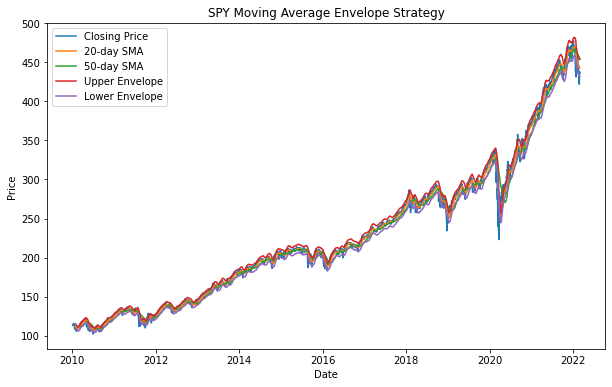

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker symbol of the ETF
ticker = 'SPY'

# Define the start and end dates for historical data
start_date = '2010-01-01'
end_date = '2022-03-01'

# Download the historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate the 20-day and 50-day moving averages
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()

# Calculate the upper and lower envelopes
data['UpperEnv'] = data['SMA20'] * 1.025
data['LowerEnv'] = data['SMA20'] * 0.975

# Plot the closing price, moving averages, and envelopes
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(data['Close'], label='Closing Price')
ax.plot(data['SMA20'], label='20-day SMA')
ax.plot(data['SMA50'], label='50-day SMA')
ax.plot(data['UpperEnv'], label='Upper Envelope')
ax.plot(data['LowerEnv'], label='Lower Envelope')

ax.set_title(f'{ticker} Moving Average Envelope Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()

# Creating Technical Indicators

In [ ]:
etf_list_final = ['IE00B1FZS467', 'IE00B1TXK627', 'IE00B1XNHC34']

# Calculate ADO // Accumultation & Distribution // 10 day money flow volume w/ 30 day
def calculate_ado(df, etf):

    df[f"{etf}_money_flow_multiplier"] = (2 * df[f"Close_{etf}"] - df[f"High_{etf}"] - df[f"Low_{etf}"]) / (df[f"High_{etf}"] - df[f"Low_{etf}"])
    df[f"{etf}_money_flow_volume"] = df[f"{etf}_money_flow_multiplier"] * df[f"Volume_{etf}"]
    df[f"{etf}_ado"] = df[f"{etf}_money_flow_volume"].rolling(window=10).sum() - df[f"{etf}_money_flow_volume"].rolling(window=30).sum()

    # Define strategy signals
    df[f"{etf}_ado_signal"] = 0
    df[f"{etf}_ado_signal"][10:] = \
        np.where(df[f"{etf}_ado"][10:] > 0, 1, -1)

    # Calculate strategy returns
    df[f"{etf}_ado_returns"] = df[f"Close_{etf}"].pct_change() * df[f"{etf}_ado_signal"].shift(1)
    df[f"{etf}_ado_cumulative_returns"] = (1 + df[f"{etf}_ado_returns"]).cumprod()

    return df 

# Calculate MAO // Moving Average Oscilator // 10 50 day moving average
def calculate_mao(df, etf, short_window ,long_window):
    
    df[f'{etf}_MA_short'] = df[f'Close_{etf}'].rolling(window=short_window).mean()
    df[f'{etf}_MA_long'] = df[f'Close_{etf}'].rolling(window=long_window).mean()
    df[f'{etf}_MAO'] = df[f'{etf}_MA_short'] - df[f'{etf}_MA_long']
    df.drop([f'{etf}_MA_short', f'{etf}_MA_long'], axis=1, inplace=True)

    # Metrics
    df[f'{etf}_MAO_Position'] = None
    df[f'{etf}_MAO_Position'][50:] = np.where(df[f'{etf}_MAO'][50:] > 0, 1, -1)

    # Calculate daily returns
    df[f'{etf}_MAO_Returns'] = df[f'Close_{etf}'].pct_change() * df[f'{etf}_MAO_Position'].shift(1)

    # Calculate cumulative returns
    df[f'{etf}_MAO_Cumulative Returns'] = (1 + df[f'{etf}_MAO_Returns']).cumprod()

    return df

for etf in etf_list_final:

    df = calculate_mao(etf_final, etf,  10, 50)
    df = calculate_ado(etf_final, etf)

df

<ipython-input-11-65e4bfe524bb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{etf}_MAO_Position'][50:] = np.where(df[f'{etf}_MAO'][50:] > 0, 1, -1)
<ipython-input-11-65e4bfe524bb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{etf}_ado_signal"][10:] = \


,Date,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Volume_IE00B1FZS467,Volume_IE00B1TXK627,Volume_IE00B1XNHC34,High_IE00B1FZS467,High_IE00B1TXK627,High_IE00B1XNHC34,...,IE00B1XNHC34_MAO,IE00B1XNHC34_MAO_Position,IE00B1XNHC34_MAO_Returns,IE00B1XNHC34_MAO_Cumulative Returns,IE00B1XNHC34_money_flow_multiplier,IE00B1XNHC34_money_flow_volume,IE00B1XNHC34_ado,IE00B1XNHC34_ado_signal,IE00B1XNHC34_ado_returns,IE00B1XNHC34_ado_cumulative_returns
0,2008-01-02,3217.959961,2831.679932,3385.090088,0.0,0,0,3217.959961,2831.679932,3385.090088,...,NaN,None,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2008-01-03,3243.129883,2847.100098,3389.239990,0.0,0,0,3243.129883,2847.100098,3389.239990,...,NaN,None,NaN,NaN,NaN,NaN,NaN,0,0.000000,1.000000
2,2008-01-04,3232.030029,2797.179932,3276.939941,0.0,0,0,3232.030029,2797.179932,3276.939941,...,NaN,None,NaN,NaN,NaN,NaN,NaN,0,-0.000000,1.000000
3,2008-01-07,3270.199951,2773.979980,3137.649902,0.0,0,0,3270.199951,2773.979980,3137.649902,...,NaN,None,NaN,NaN,NaN,NaN,NaN,0,-0.000000,1.000000
4,2008-01-08,3259.330078,2745.560059,3170.639893,0.0,0,0,3259.330078,2745.560059,3170.639893,...,NaN,None,NaN,NaN,NaN,NaN,NaN,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,2023-02-17,2549.000000,4948.000000,931.500000,45065.0,5915,1134858,2556.500000,4961.899902,938.500000,...,-14.085,-1,0.019474,-188.479051,-0.806452,-915208.064516,-2.541538e+06,-1,0.019474,-113.181742
3824,2023-02-20,2543.000000,4968.000000,935.750000,13239.0,3069,262116,2566.000000,5004.000000,942.500000,...,-16.475,-1,-0.004563,-187.619109,-0.687500,-180204.750000,-1.661169e+06,-1,-0.004563,-112.665347
3825,2023-02-21,2504.000000,4880.000000,918.750000,18463.0,5522,624145,2547.439941,4975.000000,936.750000,...,-19.480,-1,0.018167,-191.027631,-0.870130,-543087.207792,-1.507825e+06,-1,0.018167,-114.712166
3826,2023-02-22,2498.000000,4876.000000,913.750000,20606.0,7213,1530014,2498.000000,4878.000000,917.250000,...,-22.605,-1,0.005442,-192.067237,0.333333,510004.666667,-3.831497e+05,-1,0.005442,-115.336449


In [ ]:
etf_final.columns

Index(['Date', 'Close_DE0006289309', 'Close_IE00B1FZS350',
       'Close_IE00B1FZS467', 'Close_IE00B1TXK627', 'Close_IE00B1XNHC34',
       'Close_US46137V3731', 'Close_US46137V6478', 'Close_US4642873099',
       'Close_US4642873339', 'Close_US4642873412', 'Close_US4642874089',
       'Close_US4642881829', 'Close_US4642887529', 'Close_US4642887784',
       'Volume_DE0006289309', 'Volume_IE00B1FZS350', 'Volume_IE00B1FZS467',
       'Volume_IE00B1TXK627', 'Volume_IE00B1XNHC34', 'Volume_US46137V3731',
       'Volume_US46137V6478', 'Volume_US4642873099', 'Volume_US4642873339',
       'Volume_US4642873412', 'Volume_US4642874089', 'Volume_US4642881829',
       'Volume_US4642887529', 'Volume_US4642887784', 'High_DE0006289309',
       'High_IE00B1FZS350', 'High_IE00B1FZS467', 'High_IE00B1TXK627',
       'High_IE00B1XNHC34', 'High_US46137V3731', 'High_US46137V6478',
       'High_US4642873099', 'High_US4642873339', 'High_US4642873412',
       'High_US4642874089', 'High_US4642881829', 'High_US4642

In [ ]:
etf_final.to_csv(r"N:\InvSolutions\Fabricas\Analise\Diogo\Universal\Data\etf_final.csv")

In [ ]:
#----------------------------------------------------------
#                   FEATURES PARAMETERS
#----------------------------------------------------------
rsi_period = 21
macd_fast_period = 15
macd_slow_period = 26
macd_signal_period = 9
#----------------------------------------------------------

for etf in tqdm(etf_list_final):

  #ticker = yf.Ticker(etf)
  # total_assets = ticker.info['totalAssets']

  #etf_df = df_filtered[df_filtered['Symbol'] == etf]

  ### Exponential Moving Averages
  try:
    df[f'EMA_9_{etf}'] = df[f'Close_{etf}'].ewm(9).mean().shift()
    df[f'EMA_30_{etf}'] = df[f'Close_{etf}'].ewm(30).mean().shift()
    df[f'EMA_50_{etf}'] = df[f'Close_{etf}'].ewm(50).mean().shift()

    ### Simple Moving Averages
    df[f'SMA_30_{etf}'] = df[f'Close_{etf}'].rolling(30).mean().shift()
    df[f'SMA_50_{etf}'] = df[f'Close_{etf}'].rolling(50).mean().shift()
    df[f'SMA_100_{etf}'] = df[f'Close_{etf}'].rolling(100).mean().shift()
    df[f'SMA_200_{etf}'] = df[f'Close_{etf}'].rolling(200).mean().shift()

    ### Price changes // Returns 
    #### TODO // DOUBLE CHECK THIS
    df[f'5D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 5)
    df[f'15D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 15)
    df[f'30D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 30)
    df[f'90D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 90)
    df[f'180D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 180)
    df[f'360D_Ret_{etf}'] = df[f'Close_{etf}'].pct_change(periods = 360)

    # RSI
    df[f'RSI_{etf}'] = ta.RSI(df[f'Close_{etf}'], timeperiod=rsi_period)

    # Stochastic Oscillator
    #data["stochastic_k"], data["stochastic_d"] = talib.STOCH(data["High"], data["Low"], data["Close"], fastk_period=14, slowk_period=3, slowd_period=3)

    # ATX

    # Flow = # SHARES OUTSTANDING
    #etf_volume = etf_final[f'Volume_{etf}']
    #etf_close = etf_final[f'Close_{etf}']


    #----------------------------------------------------------
    # Compute the daily flows for each ETF  
    #---------------------------------------------------------- 
    # THIS COL STILL NEEDS SOME WORK
    #----------------------------------------------------------

    #etf_final[f'Daily_Flows_{etf}'] = etf_volume * etf_close.diff()

    # Dont forget to convert to log returns 
    df[f'Log_15D_Ret_{etf}'] = np.log(1 + df[f'15D_Ret_{etf}'])
    df[f'Log_5D_Ret_{etf}'] = np.log(1 + df[f'5D_Ret_{etf}'])
    df[f'Log_30D_Ret_{etf}'] = np.log(1 + df[f'30D_Ret_{etf}'])
    df[f'Log_90D_Ret_{etf}'] = np.log(1 + df[f'90D_Ret_{etf}'])
    df[f'Log_180D_Ret_{etf}'] = np.log(1 + df[f'180D_Ret_{etf}'])
    df[f'Log_360D_Ret_{etf}'] = np.log(1 + df[f'360D_Ret_{etf}'])
    #----------------------------------------------------------
    #----------------------------------------------------------
  except:
    print(etf)
    pass

print(df.tail(2))

100%|██████████| 3/3 [00:00<00:00, 36.09it/s]

IE00B1FZS467
IE00B1TXK627
IE00B1XNHC34
           Date  Close_IE00B1FZS467  Close_IE00B1TXK627  Close_IE00B1XNHC34  \
3826 2023-02-22              2498.0              4876.0              913.75   
3827 2023-02-23              2496.0              4854.5              912.25   

      Close_IE00BF0M2Z96  Close_IE00BF16M727  Close_IE00BG0J4841  \
3826              17.646                 NaN               7.005   
3827              17.677                 NaN               6.981   

      Close_IE00BJGWQN72  Close_IE00BYZK45520  Close_IE00BYZK4669  ...  \
3826             2352.75                  NaN              6.6825  ...   
3827             2336.00                  NaN              6.6700  ...   

      SMA_30_IE00B1XNHC34  SMA_50_IE00B1XNHC34  SMA_100_IE00B1XNHC34  \
3826           958.020833               956.48              959.9800   
3827           955.779167               955.43              959.1025   

      SMA_200_IE00B1XNHC34  5D_Ret_IE00B1XNHC34  15D_Ret_IE00B1XNHC34  \
3826 

In [ ]:
etf_final.columns

Index(['IE00B1FZS467', 'IE00B1TXK627', 'IE00B1XNHC34', 'IE00BF16M727',
       'IE00BG0J4841', 'IE00BJGWQN72', 'IE00BYZK45520', 'IE00BYZK4669',
       'IE00BYZK4776', 'IE00BYZK4883', 'Date', 'IE00B1FZS467', 'IE00B1TXK627',
       'IE00B1XNHC34', 'IE00BF16M727', 'IE00BG0J4841', 'IE00BJGWQN72',
       'IE00BYZK45520', 'IE00BYZK4669', 'IE00BYZK4776', 'IE00BYZK4883'],
      dtype='object')

In [ ]:
etf_final.shape

(7400, 21)

# Data Treatment

In [ ]:
#df.columns

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

EMA_12 = pd.Series(df['Close_IE00B1XNHC34'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close_IE00B1XNHC34'].ewm(span=26, min_periods=26).mean())
MACD = pd.Series(EMA_12 - EMA_26)
MACD_signal = pd.Series(MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close_IE00B1XNHC34, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=MACD, name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=MACD_signal, name='Signal line'), row=2, col=1)
fig.show()

In [ ]:
filter_col = [col for col in etf_final if col.startswith('Close')]
filter_col

In [ ]:
number_of_cols = df.columns.str.contains("Close")

In [ ]:
plot_rows=3
plot_cols=6
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# add traces
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        #print(str(i)+ ', ' + str(j))
        fig.add_trace(go.Box(y=df[df.columns[x]].values,
                                 name = df.columns[x],
                            ),
                     row=i,
                     col=j)

        x=x+1

In [ ]:
#closing_prices = etf_final.iloc[:, 'Date'].values
#closing_prices

In [ ]:
!pip install dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import plotly.graph_objs as go

<ipython-input-97-17621307e4dc>:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

<ipython-input-97-17621307e4dc>:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [ ]:
!pip install iexfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 2.4 MB/s eta 0:00:00


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html 
from dash.dependencies import Input, Output 
import requests 
import plotly.graph_objects as go
app = dash.Dash() 
app.layout = html.Div([ 
  html.H1('Financial Dashboard'), 
  html.Div([ dcc.Input(id='company_selection',value='AAPL'), 
  html.H3(id='text'), dcc.Graph(id ='revenue'),
  dcc.Graph(id ='netincome'), ],style= {'padding':10})
 ]) 

@app.callback(Output('revenue','figure'),         [Input('company_selection','value')])
def retrieve_revenue(company):
  
  demo = 'd648e73c222a4199980a66584bbf9b1c' 
  stock = company 
  print(stock)
  IS = requests.get(f'https://financialmodelingprep.com/api/v3/financials/income-statement/{company}?apikey={demo}')
  IS = IS.json()
  IS = IS['financials'] 
  Revenues = []
  Dates = []
  count = 0
  for item in IS:
    Revenues.append(float(IS[count]['Revenue'])) 
    Dates.append(IS[count]['date']) 
    count += 1 
  datapoints = {'data': [go.Bar(x=Dates, y=Revenues)],'layout':   dict(xaxis={'title':'Date'}, yaxis={'title':'Revenue'}, )} 
  
  return datapoints
  
@app.callback(Output('netincome','figure'), [Input('company_selection','value')]) 
def retrieve_revenue(company): 
  demo = 'd648e73c222a4199980a66584bbf9b1c' 
  stock = company 
  IS = requests.get(f'https://financialmodelingprep.com/api/v3/financials/income-statement/{company}?apikey={demo}') 
  IS = IS.json() 
  IS = IS['financials'] 
  Revenues = [] 
  Dates = [] 
  count = 0 
  for item in IS: 
    Revenues.append(float(IS[count]['Net Income']))   
    Dates.append(IS[count]['date'])
    count += 1
  datapoints = {'data': [go.Bar(x=Dates, y=Revenues,marker_color='lightsalmon',name='Net Income')], 'layout': dict(xaxis={'title':'Date'}, yaxis={'title':'Net Income'}, )}
  
  return datapoints 

@app.callback( Output(component_id='text', component_property='children'), [Input(component_id='company_selection', component_property='value')] ) 
def update_output_div(input_value): 
  return 'Displaying Data for "{}"'.format(input_value)

if __name__ == '__main__': app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on


# Dimensionality Reduction: PCA & WaveLet

In [ ]:
etf_final['Close_XLE'].values

array([26.5625    , 26.0625    , 26.75      , ..., 88.34999847,
       87.55999756, 86.80999756])

In [ ]:
etf_final.columns

Index(['Close_XLB', 'Close_XLE', 'Close_XLF', 'Close_XLI', 'Close_XLK',
       'Close_XLP', 'Close_XLU', 'Close_XLV', 'Close_XLY', 'Volume_XLB',
       ...
       'Log_30D_Ret_XLB', 'Log_90D_Ret_XLB', 'Log_180D_Ret_XLB',
       'Log_360D_Ret_XLB', 'Log_15D_Ret_XLU', 'Log_5D_Ret_XLU',
       'Log_30D_Ret_XLU', 'Log_90D_Ret_XLU', 'Log_180D_Ret_XLU',
       'Log_360D_Ret_XLU'],
      dtype='object', length=208)

In [ ]:
etf_final.drop('Close_XLE', axis=1).values

array([[25.96875, 18.58245277404785, 28.84375, ..., nan, nan, nan],
       [25.71875, 17.770105361938477, 28.046875, ..., nan, nan, nan],
       [26.78125, 17.630483627319336, 27.921875, ..., nan, nan, nan],
       ...,
       [83.5999984741211, 37.0, 102.91999816894531, ...,
        -0.016371206503814986, -0.04400712689942313,
        -0.014213485781726898],
       [82.93000030517578, 36.779998779296875, 102.33999633789062, ...,
        0.007605651523947011, -0.06373966457519574, -0.04018596027560052],
       [81.7300033569336, 36.369998931884766, 101.41999816894531, ...,
        0.013343598184630188, -0.08941846727549259, -0.04563639304704144]],
      dtype=object)

In [ ]:
etf_final.drop(f'Close_{etf}', axis = 1).columns

Index(['Close_XLB', 'Close_XLE', 'Close_XLF', 'Close_XLI', 'Close_XLK',
       'Close_XLP', 'Close_XLV', 'Close_XLY', 'Volume_XLB', 'Volume_XLE',
       ...
       'Log_30D_Ret_XLB', 'Log_90D_Ret_XLB', 'Log_180D_Ret_XLB',
       'Log_360D_Ret_XLB', 'Log_15D_Ret_XLU', 'Log_5D_Ret_XLU',
       'Log_30D_Ret_XLU', 'Log_90D_Ret_XLU', 'Log_180D_Ret_XLU',
       'Log_360D_Ret_XLU'],
      dtype='object', length=206)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#- -----------------------------------------------------------------------
### apply PCA to each ETF and respective indicators to get the most important ones
#- -----------------------------------------------------------------------

### Exclude date from the analysis

#date_col = etf_final['Date']
#etf_final = etf_final.drop('Date', axis = 1)

etf_final = etf_final.dropna()

for etf in etf_list:

  closing_prices = etf_final[f'Close_{etf}'].values  #etf_final.iloc[:, 0].values
  indicators = etf_final.drop(f'Close_{etf}', axis = 1).values  #etf_final.iloc[:, 1:].values


  # TODO // NORMAliZE / STANDARDIZE DATA BEFORE  


  # TODO // CHOOSE OPTIMAL NUMBER OF COMPONENTS FOR PCA
  pca = PCA(n_components=6)
  pca.fit(indicators)
  pc_scores = pca.transform(indicators)

  # Get the loadings of each indicator on the principal component
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  # Create a dataframe of the indicator loadings on the principal component
  indicator_names = etf_final.drop(f'Close_{etf}', axis = 1).columns


  initial_feature_names = etf_final.drop(f'Close_{etf}', axis = 1).columns
  most_important = [np.abs(pca.components_[i]).argmax() for i in range(6)]
  most_important_names = [initial_feature_names[most_important[i]] for i in range(6)]

  print("------------------------------------------------------------------------")
  print("Most important indicators for || ",etf," || are:", most_important_names, "as of", str(date.today()))
  print("------------------------------------------------------------------------")
  
  # loadings_df = pd.DataFrame(loadings, columns=['PC1 Loadings'], index=indicator_names)

  # Sort the loadings in descending order to find the most important indicators
  
  # loadings_df.sort_values(by='PC1 Loadings', ascending=False, inplace=True)

  # print(loadings_df)


------------------------------------------------------------------------
Most important indicators for XLY are: ['Volume_XLF', 'Daily_Flows_XLF', 'Daily_Flows_XLE', 'Daily_Flows_XLK', 'Volume_XLE', 'Daily_Flows_XLU'] as of 2023-02-23
------------------------------------------------------------------------
------------------------------------------------------------------------
Most important indicators for XLP are: ['Volume_XLF', 'Daily_Flows_XLF', 'Daily_Flows_XLE', 'Daily_Flows_XLK', 'Volume_XLE', 'Daily_Flows_XLU'] as of 2023-02-23
------------------------------------------------------------------------
------------------------------------------------------------------------
Most important indicators for XLE are: ['Volume_XLF', 'Daily_Flows_XLF', 'Daily_Flows_XLE', 'Daily_Flows_XLK', 'Volume_XLE', 'Daily_Flows_XLU'] as of 2023-02-23
------------------------------------------------------------------------
------------------------------------------------------------------------
Most i

In [ ]:
initial_feature_names = etf_final.drop(f'Close_{etf}', axis = 1).columns
most_important = [np.abs(pca.components_[i]).argmax() for i in range(6)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(6)]

most_important_names

['Volume_XLF',
 'Daily_Flows_XLF',
 'Daily_Flows_XLE',
 'Daily_Flows_XLK',
 'Volume_XLE',
 'Daily_Flows_XLU']

In [ ]:
pca.n_components_

6

In [ ]:
pc_scores

array([[-64027976.56297347,  -9229129.03904838,   3991715.77045427,
         -1099054.49352779, -16118603.51070612,    378785.13611824],
       [-64519629.98647466,  -9383875.19482089,   3994126.22762014,
          -805154.32200494, -16221006.93057626,    253576.14747757],
       [-65022989.2658313 ,  -9483260.31499426,   4077516.18577695,
          -698113.16185264, -16037329.81247632,    199596.03197178],
       ...,
       [-27178736.82110886, -42817597.20133292, -47590885.6728927 ,
         -1483462.11649902,  10829032.7472293 ,  13446848.43925805],
       [-29117073.1903021 ,  10116591.99917206,  12023083.701828  ,
         12798923.02819192,    691414.25178321,   4634239.68413629],
       [-20604382.2191429 ,  21408122.74333283,   8155749.19775854,
          8724393.91618451,   1960714.09934418,   7576360.81638371]])

In [ ]:
loadings.shape

(206, 6)

In [ ]:
indicator_names.shape

(206,)

# Modelling

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

indicators = []

etf_final.dropna(inplace=True)

# TODO // CREATE A BETTER TARGET COLUMN 
etf_final['Target'] = etf_final['Close'].shift(-1)

# Remove the last row (which has a missing value for the target variable)
etf_final.dropna(inplace=True)

# Define the input features (indicators) and the target variable
X = etf_final[indicators]
y = etf_final['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost model and fit it to the training data
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, verbose = 2)
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Compute the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

# Weights Optimization

In [7]:
from tqdm import tqdm 

momentum_weights = [[0.23,	0.76,	0.01],
                [0.66,	0.14,	0.2],
                [0.01,	0.81,	0.18],
                [0.74,	0.2,	0.06],
                [0.22,	0.4,	0.38],
                [0.28,	0.47,	0.25],
                [0.53,	0.13,	0.34],
                [0.56,	0.33,	0.11],
                [0.03,	0.74,	0.23],
                [0.01,	0.93,	0.06],
                [0.36,	0.18,	0.46],
                [0.17,	0.12,	0.71],
                [0.39,	0.2,	0.41],
                [0.48,	0.19,	0.33],
                [0.25,	0.54,	0.21],
                [0.27,	0.55,	0.18],
                [0.02,	0.41,	0.57],
                [0.57,	0.41,	0.02],
                [0.19,	0.46,	0.35],
                [0.71,	0.24,	0.05],
                [0.19,	0.74,	0.07],
                [0.65,	0.19,	0.16],
                [0.8,	0.12,	0.08],
                [0.41,	0.21,	0.38],
                [0.71,	0.15,	0.14],
                [0.47,	0.06,	0.47],
                [0.23,	0.36,	0.41],
                [0.61,	0.1,	0.29],
                [0.09,	0.13,	0.78],
                [0.38,	0.11,	0.51],
                [0.84,	0.06,	0.1],
                [0.38,	0.07,	0.55],
                [0.26,	0.11,	0.63],
                [0.37,	0.17,	0.46],
                [0.11,	0.01,	0.88],
                [0.53,	0.26,	0.21],
                [0.1,	0.68,	0.22],
                [0.01,	0.94,	0.05],
                [0.9,	0.1,	0],
                [0.46,	0.19,	0.35],
                [0.69,	0.1,	0.21],
                [0.17,	0.49,	0.34],
                [0.52,	0.28,	0.2],
                [0.13,	0.35,	0.52],
                [0.01,	0.02,	0.97],
                [0.6,	0.05,	0.35],
                [0.46,	0.39,	0.15],
                [0.05,	0.22,	0.73],
                [0.75,	0.02,	0.23],
                [0.16,	0.07,	0.77],
                [0.54,	0.08,	0.38],
                [0.92,	0.04,	0.04],
                [0.27,	0.38,	0.35],
                [0.71,	0.17,	0.12],
                [0.01,	0.11,	0.88],
                [0.14,	0.38,	0.48],
                [0.33,	0.61,	0.06],
                [0.49,	0.4,	0.11],
                [0.22,	0.28,	0.5],
                [0.05,	0.55,	0.4],
                [0.14,	0.26,	0.6],
                [0.13,	0.36,	0.51],
                [0.15,	0.07,	0.78],
                [0.03,	0.73,	0.24],
                [0.24,	0.76,	0],
                [0.02,	0.3,	0.68],
                [0.06,	0.24,	0.7],
                [0.4,	0.51,	0.09],
                [0.2,	0.27,	0.53],
                [0.97,	0.01,	0.02],
                [0.7,	0.08,	0.22],
                [0.28,	0.68,	0.04],
                [0.13,	0.63,	0.24],
                [0.19,	0.41,	0.4],
                [0.17,	0.35,	0.48],
                [0.26,	0.5,	0.24],
                [0.41,	0.55,	0.04],
                [0.5,	0.16,	0.34],
                [0.53,	0.16,	0.31],
                [0.55,	0.03,	0.42],
                [0.22,	0.34,	0.44],
                [0.04,	0.66,	0.3],
                [0.39,	0.16,	0.45],
                [0.11,	0.33,	0.56],
                [0.08,	0.11,	0.81],
                [0.33,	0.52,	0.15],
                [0.57,	0.32,	0.11],
                [0.23,	0.2,	0.57],
                [0.32,	0.25,	0.43],
                [0.52,	0.12,	0.36],
                [0.11,	0.79,	0.1],
                [0.19,	0.56,	0.25],
                [0.14,	0.52,	0.34],
                [0.33,	0.25,	0.42],
                [0.31,	0.46,	0.23],
                [0.13,	0.2,	0.67],
                [0.31,	0.61,	0.08],
                [0.05,	0.91,	0.04],
                [0.02,	0.83,	0.15],
                [0.47,	0.15,	0.38],
                [0.37,	0.44,	0.19],
                [0.21,	0.77,	0.02],
                [0.63,	0.11,	0.26],
                [0.63,	0.18,	0.19],
                [0.33,	0.33,	0.34],
                [0.2,	0.11,	0.69],
                [0.53,	0.14,	0.33],
                [0.43,	0.25,	0.32],
                [0.32,	0.01,	0.67],
                [0.4,	0.35,	0.25],
                [0.4,	0.21,	0.39],
                [0.35,	0.19,	0.46],
                [0.23,	0.49,	0.28],
                [0.07,	0.74,	0.19],
                [0.11,	0.7,	0.19],
                [0.59,	0.15,	0.26],
                [0.46,	0.42,	0.12],
                [0.09,	0.06,	0.85],
                [0.13,	0.21,	0.66],
                [0.89,	0.03,	0.08],
                [0.75,	0.17,	0.08],
                [0.03,	0.21,	0.76],
                [0.65,	0.22,	0.13],
                [0.72,	0.12,	0.16],
                [0.53,	0.17,	0.3],
                [0.21,	0.7,	0.09],
                [0.13,	0.73,	0.14],
                [0.5,	0.26,	0.24],
                [0.63,	0.15,	0.22],
                [0.03,	0.66,	0.31],
                [0.7,	0.25,	0.05],
                [0.01,	0.25,	0.74],
                [0.07,	0.27,	0.66],
                [0.22,	0.02,	0.76],
                [0.38,	0.12,	0.5],
                [0.51,	0.27,	0.22],
                [0.08,	0.16,	0.76],
                [0.11,	0.37,	0.52],
                [0.47,	0.36,	0.17],
                [0.65,	0.35,	0],
                [0.21,	0.69,	0.1],
                [0.65,	0.28,	0.07],
                [0.21,	0.52,	0.27],
                [0.17,	0.37,	0.46],
                [0.09,	0.1,	0.81],
                [0.32,	0.42,	0.26],
                [0.27,	0.23,	0.5],
                [0.47,	0.51,	0.02],
                [0.35,	0.07,	0.58],
                [0.49,	0.26,	0.25],
                [0.04,	0.09,	0.87],
                [0.14,	0.33,	0.53],
                [0.23,	0.68,	0.09],
                [0.47,	0.26,	0.27],
                [0.23,	0.05,	0.72],
                [0.2,	0.01,	0.79],
                [0.42,	0.4,	0.18],
                [0.63,	0.28,	0.09],
                [0.23,	0.64,	0.13],
                [0.16,	0.1,	0.74],
                [0.18,	0.29,	0.53],
                [0.81,	0.02,	0.17],
                [0.01,	0.34,	0.65],
                [0.11,	0.07,	0.82],
                [0.13,	0.85,	0.02],
                [0.31,	0.15,	0.54],
                [0.4,	0.6,	0],
                [0.19,	0.64,	0.17],
                [0.05,	0.48,	0.47],
                [0.11,	0.13,	0.76],
                [0.16,	0.2,	0.64],
                [0.54,	0.45,	0.01],
                [0.24,	0.45,	0.31],
                [0.93,	0.04,	0.03],
                [0.15,	0.67,	0.18],
                [0.42,	0.35,	0.23],
                [0.67,	0.23,	0.1],
                [0.07,	0.56,	0.37],
                [0.29,	0.58,	0.13],
                [0.66,	0.31,	0.03],
                [0.24,	0.4,	0.36],
                [0.15,	0.78,	0.07],
                [0.25,	0.01,	0.74],
                [0.1,	0.87,	0.03],
                [0.5,	0.06,	0.44],
                [0.63,	0.2,	0.17],
                [0.72,	0.15,	0.13],
                [0.33,	0.17,	0.5],
                [0.22,	0.33,	0.45],
                [0.07,	0.52,	0.41],
                [0.39,	0.14,	0.47],
                [0.24,	0.28,	0.48],
                [0.56,	0.16,	0.28],
                [0.63,	0.33,	0.04],
                [0.68,	0.09,	0.23],
                [0.79,	0.13,	0.08],
                [0.08,	0.36,	0.56],
                [0.37,	0.12,	0.51],
                [0.36,	0.32,	0.32],
                [0.47,	0.47,	0.06],
                [0.21,	0.07,	0.72],
                [0.72,	0.09,	0.19],
                [0.74,	0.02,	0.24],
                [0.45,	0.03,	0.52],
                [0.25,	0.74,	0.01],
                [0.58,	0.28,	0.14],
                [0.09,	0.43,	0.48],
                [0.28,	0.04,	0.68],
                [0.53,	0.23,	0.24],
                [0.01,	0.98,	0.01],
                [0.91,	0.08,	0.01],
                [0.63,	0.25,	0.12],
                [0.28,	0.15,	0.57],
                [0.06,	0.4,	0.54],
                [0.22,	0.27,	0.51],
                [0.02,	0.36,	0.62],
                [0.77,	0.07,	0.16],
                [0.26,	0.1,	0.64],
                [0.38,	0.14,	0.48],
                [0.5,	0.15,	0.35],
                [0.35,	0.33,	0.32],
                [0.21,	0.66,	0.13],
                [0.16,	0.63,	0.21],
                [0.74,	0.24,	0.02],
                [0.62,	0.07,	0.31],
                [0.4,	0.43,	0.17],
                [0.69,	0.12,	0.19],
                [0.29,	0.43,	0.28],
                [0.25,	0.63,	0.12],
                [0.22,	0.68,	0.1],
                [0.04,	0.54,	0.42],
                [0.5,	0.42,	0.08],
                [0.45,	0.38,	0.17],
                [0.17,	0.55,	0.28],
                [0.02,	0.13,	0.85],
                [0.87,	0.09,	0.04],
                [0.11,	0.83,	0.06],
                [0.24,	0.64,	0.12],
                [0.07,	0.48,	0.45],
                [0.16,	0.25,	0.59],
                [0.34,	0.43,	0.23],
                [0.73,	0.13,	0.14],
                [0.22,	0.06,	0.72],
                [0.66,	0.16,	0.18],
                [0.44,	0.45,	0.11],
                [0.49,	0.16,	0.35],
                [0.25,	0.58,	0.17],
                [0.46,	0.31,	0.23],
                [0.75,	0.19,	0.06],
                [0.09,	0.87,	0.04],
                [0.81,	0.06,	0.13],
                [0.21,	0.64,	0.15],
                [0.1,	0.1,	0.8],
                [0.34,	0.14,	0.52],
                [0.62,	0.33,	0.05],
                [0.46,	0.43,	0.11],
                [0.45,	0.1,	0.45],
                [0.59,	0.29,	0.12],
                [0.01,	0.65,	0.34],
                [0.22,	0.39,	0.39],
                [0.02,	0.6,	0.38],
                [0.15,	0.02,	0.83],
                [0.58,	0.3,	0.12],
                [0.35,	0.25,	0.4],
                [0.5,	0.27,	0.23],
                [0.61,	0.28,	0.11],
                [0.12,	0.59,	0.29],
                [0.33,	0.13,	0.54],
                [0.44,	0.22,	0.34],
                [0.04,	0.34,	0.62],
                [0.44,	0.04,	0.52],
                [0.11,	0.6,	0.29],
                [0.26,	0.65,	0.09],
                [0.5,	0.1,	0.4],
                [0.02,	0.56,	0.42],
                [0.16,	0.6,	0.24],
                [0.93,	0.01,	0.06],
                [0.18,	0.61,	0.21],
                [0.21,	0.67,	0.12],
                [0.77,	0.23,	0],
                [0.18,	0.05,	0.77],
                [0.28,	0.14,	0.58],
                [0.16,	0.09,	0.75],
                [0.05,	0.62,	0.33],
                [0.02,	0.87,	0.11],
                [0.96,	0.03,	0.01],
                [0.26,	0.56,	0.18],
                [0.71,	0.01,	0.28],
                [0.2,	0.16,	0.64],
                [0.73,	0.21,	0.06],
                [0.48,	0.17,	0.35],
                [0.55,	0.15,	0.3],
                [0.71,	0.16,	0.13],
                [0.12,	0.33,	0.55],
                [0.32,	0.27,	0.41],
                [0.7,	0.2,	0.1],
                [0.51,	0.31,	0.18],
                [0.68,	0.32,	0],
                [0.8,	0.09,	0.11],
                [0.24,	0.35,	0.41],
                [0.28,	0.41,	0.31],
                [0.46,	0.44,	0.1],
                [0.85,	0.14,	0.01],
                [0.39,	0.6,	0.01],
                [0.05,	0.19,	0.76],
                [0.82,	0.01,	0.17],
                [0.33,	0.27,	0.4],
                [0.3,	0.54,	0.16],
                [0.36,	0.34,	0.3],
                [0.6,	0.21,	0.19],
                [0.57,	0.37,	0.06],
                [0.91,	0.06,	0.03],
                [0.69,	0.13,	0.18],
                [0.48,	0.14,	0.38],
                [0.04,	0.3,	0.66],
                [0.45,	0.32,	0.23],
                [0.03,	0.76,	0.21],
                [0.34,	0.37,	0.29],
                [0.57,	0.18,	0.25],
                [0.6,	0.26,	0.14],
                [0.24,	0.41,	0.35],
                [0.53,	0.15,	0.32],
                [0.02,	0.2,	0.78],
                [0.56,	0.22,	0.22],
                [0.22,	0.46,	0.32],
                [0.17,	0.33,	0.5],
                [0.01,	0.43,	0.56],
                [0.16,	0.54,	0.3],
                [0.32,	0.06,	0.62],
                [0.04,	0.67,	0.29],
                [0.23,	0.75,	0.02],
                [0.29,	0.15,	0.56],
                [0.19,	0.54,	0.27],
                [0.25,	0.42,	0.33],
                [0.21,	0.12,	0.67],
                [0.12,	0.46,	0.42],
                [0.03,	0.1,	0.87],
                [0.45,	0.28,	0.27],
                [0.19,	0.77,	0.04],
                [0.65,	0.01,	0.34],
                [0.06,	0.22,	0.72],
                [0.08,	0.89,	0.03],
                [0.17,	0.34,	0.49],
                [0.48,	0.37,	0.15],
                [0.9,	0.05,	0.05],
                [0.03,	0.91,	0.06],
                [0.27,	0.46,	0.27],
                [0.01,	0.73,	0.26],
                [0.28,	0.51,	0.21],
                [0.21,	0.45,	0.34],
                [0.42,	0.42,	0.16],
                [0.63,	0.22,	0.15],
                [0.01,	0.49,	0.5],
                [0.73,	0.01,	0.26],
                [0.32,	0.46,	0.22],
                [0.44,	0.07,	0.49],
                [0.41,	0.05,	0.54],
                [0.02,	0.09,	0.89],
                [0.15,	0.46,	0.39],
                [0.22,	0.09,	0.69],
                [0.13,	0.07,	0.8],
                [0.07,	0.43,	0.5],
                [0.02,	0.82,	0.16],
                [0.46,	0.1,	0.44],
                [0.42,	0.21,	0.37],
                [0.42,	0.08,	0.5],
                [0.25,	0.4,	0.35],
                [0.04,	0.23,	0.73],
                [0.42,	0.2,	0.38],
                [0.21,	0.33,	0.46],
                [0.56,	0.34,	0.1],
                [0.52,	0.23,	0.25],
                [0.17,	0.02,	0.81],
                [0.36,	0.26,	0.38],
                [0.2,	0.07,	0.73],
                [0.1,	0.17,	0.73],
                [0.33,	0.15,	0.52],
                [0.31,	0.67,	0.02],
                [0.33,	0.03,	0.64],
                [0.12,	0.78,	0.1],
                [0.11,	0.86,	0.03],
                [0.36,	0.31,	0.33],
                [0.1,	0.04,	0.86],
                [0.13,	0.04,	0.83],
                [0.52,	0.13,	0.35],
                [0.35,	0.63,	0.02],
                [0.48,	0.39,	0.13],
                [0.09,	0.57,	0.34],
                [0.31,	0.59,	0.1],
                [0.45,	0.29,	0.26],
                [0.65,	0.16,	0.19],
                [0.19,	0.11,	0.7],
                [0.38,	0.53,	0.09],
                [0.34,	0.25,	0.41],
                [0.29,	0.41,	0.3],
                [0.79,	0.16,	0.05],
                [0.37,	0.28,	0.35],
                [0.66,	0.26,	0.08],
                [0.09,	0.05,	0.86],
                [0.3,	0.09,	0.61],
                [0.34,	0.11,	0.55],
                [0.5,	0.46,	0.04],
                [0.65,	0.15,	0.2],
                [0.23,	0.3,	0.47],
                [0.14,	0.03,	0.83],
                [0.38,	0.51,	0.11],
                [0.02,	0.39,	0.59],
                [0.31,	0.27,	0.42],
                [0.24,	0.3,	0.46],
                [0.2,	0.43,	0.37],
                [0.22,	0.5,	0.28],
                [0.1,	0.27,	0.63],
                [0.28,	0.46,	0.26],
                [0.3,	0.28,	0.42],
                [0.47,	0.33,	0.2],
                [0.37,	0.59,	0.04],
                [0.46,	0.15,	0.39],
                [0.39,	0.04,	0.57],
                [0.26,	0.58,	0.16],
                [0.3,	0.69,	0.01],
                [0.49,	0.41,	0.1],
                [0.69,	0.07,	0.24],
                [0.13,	0.52,	0.35],
                [0.11,	0.1,	0.79],
                [0.6,	0.12,	0.28],
                [0.1,	0.43,	0.47],
                [0.18,	0.67,	0.15],
                [0.4,	0.2,	0.4],
                [0.29,	0.51,	0.2],
                [0.15,	0.84,	0.01],
                [0.75,	0.11,	0.14],
                [0.09,	0.31,	0.6],
                [0.04,	0.65,	0.31],
                [0.54,	0.09,	0.37],
                [0.07,	0.62,	0.31],
                [0.36,	0.43,	0.21],
                [0.06,	0.54,	0.4],
                [0.57,	0.11,	0.32],
                [0.2,	0.1,	0.7],
                [0.43,	0.3,	0.27],
                [0.72,	0.27,	0.01],
                [0.74,	0.17,	0.09],
                [0.4,	0.1,	0.5],
                [0.67,	0.32,	0.01],
                [0.22,	0.49,	0.29],
                [0.44,	0.48,	0.08],
                [0.06,	0.64,	0.3],
                [0.18,	0.5,	0.32],
                [0.77,	0.14,	0.09],
                [0.77,	0.11,	0.12],
                [0.57,	0.38,	0.05],
                [0.54,	0.41,	0.05],
                [0.14,	0.24,	0.62],
                [0.07,	0.54,	0.39],
                [0.32,	0.37,	0.31],
                [0.52,	0.43,	0.05],
                [0.27,	0.7,	0.03],
                [0.99,	0.01,	0],
                [0.37,	0.47,	0.16],
                [0.51,	0.49,	0],
                [0.03,	0.38,	0.59],
                [0.7,	0.17,	0.13],
                [0.62,	0.01,	0.37],
                [0.03,	0.71,	0.26],
                [0.29,	0.2,	0.51],
                [0.11,	0.72,	0.17],
                [0.38,	0.17,	0.45],
                [0.1,	0.08,	0.82],
                [0.49,	0.23,	0.28],
                [0.34,	0.5,	0.16],
                [0.34,	0.49,	0.17],
                [0.69,	0.14,	0.17],
                [0.23,	0.77,	0],
                [0.58,	0.01,	0.41],
                [0.03,	0.84,	0.13],
                [0.89,	0.07,	0.04],
                [0.16,	0.08,	0.76],
                [0.05,	0.29,	0.66],
                [0.05,	0.68,	0.27],
                [0.11,	0.5,	0.39],
                [0.1,	0.61,	0.29],
                [0.35,	0.21,	0.44],
                [0.17,	0.21,	0.62],
                [0.13,	0.41,	0.46],
                [0.12,	0.35,	0.53],
                [0.46,	0.45,	0.09],
                [0.7,	0.02,	0.28],
                [0.16,	0.03,	0.81],
                [0.19,	0.8,	0.01],
                [0.29,	0.01,	0.7],
                [0.51,	0.3,	0.19],
                [0.45,	0.21,	0.34],
                [0.34,	0.45,	0.21],
                [0.16,	0.41,	0.43],
                [0.32,	0.57,	0.11],
                [0.71,	0.12,	0.17],
                [0.29,	0.44,	0.27],
                [0.13,	0.01,	0.86],
                [0.09,	0.53,	0.38],
                [0.72,	0.04,	0.24],
                [0.12,	0.36,	0.52],
                [0.53,	0.04,	0.43],
                [0.01,	0.63,	0.36],
                [0.18,	0.02,	0.8],
                [0.07,	0.93,	0],
                [0.24,	0.13,	0.63],
                [0.7,	0.26,	0.04],
                [0.12,	0.69,	0.19],
                [0.17,	0.7,	0.13],
                [0.02,	0.42,	0.56],
                [0.13,	0.76,	0.11],
                [0.48,	0.3,	0.22],
                [0.48,	0.44,	0.08],
                [0.04,	0.14,	0.82],
                [0.68,	0.12,	0.2],
                [0.28,	0.7,	0.02],
                [0.22,	0.67,	0.11],
                [0.16,	0.57,	0.27],
                [0.64,	0.22,	0.14],
                [0.24,	0.66,	0.1],
                [0.47,	0.37,	0.16],
                [0.57,	0.16,	0.27],
                [0.61,	0.18,	0.21],
                [0.6,	0.15,	0.25],
                [0.46,	0.28,	0.26],
                [0.41,	0.27,	0.32],
                [0.02,	0.22,	0.76],
                [0.44,	0.02,	0.54],
                [0.62,	0.17,	0.21],
                [0.29,	0.14,	0.57],
                [0.49,	0.15,	0.36],
                [0.01,	0.18,	0.81],
                [0.66,	0.09,	0.25],
                [0.16,	0.32,	0.52],
                [0.51,	0.29,	0.2],
                [0.52,	0.04,	0.44],
                [0.3,	0.42,	0.28],
                [0.5,	0.5,	0],
                [0.8,	0.18,	0.02],
                [0.47,	0.04,	0.49],
                [0.46,	0.35,	0.19],
                [0.16,	0.23,	0.61],
                [0.1,	0.38,	0.52],
                [0.19,	0.75,	0.06],
                [0.47,	0.18,	0.35],
                [0.14,	0.71,	0.15],
                [0.08,	0.81,	0.11],
                [0.02,	0.97,	0.01],
                [0.27,	0.22,	0.51],
                [0.24,	0.49,	0.27],
                [0.41,	0.15,	0.44],
                [0.07,	0.26,	0.67],
                [0.46,	0.01,	0.53],
                [0.18,	0.81,	0.01],
                [0.51,	0.06,	0.43],
                [0.42,	0.45,	0.13],
                [0.22,	0.78,	0],
                [0.23,	0.42,	0.35],
                [0.7,	0.13,	0.17],
                [0.48,	0.07,	0.45],
                [0.69,	0.18,	0.13],
                [0.07,	0.2,	0.73],
                [0.8,	0.1,	0.1],
                [0.19,	0.32,	0.49],
                [0.28,	0.52,	0.2],
                [0.11,	0.15,	0.74],
                [0.25,	0.56,	0.19],
                [0.78,	0.11,	0.11],
                [0.73,	0.16,	0.11],
                [0.01,	0.9,	0.09],
                [0.27,	0.43,	0.3],
                [0.25,	0.27,	0.48],
                [0.72,	0.06,	0.22],
                [0.01,	0.04,	0.95],
                [0.26,	0.21,	0.53],
                [0.09,	0.55,	0.36],
                [0.15,	0.13,	0.72],
                [0.05,	0.9,	0.05],
                [0.52,	0.4,	0.08],
                [0.27,	0.07,	0.66],
                [0.33,	0.49,	0.18],
                [0.56,	0.35,	0.09],
                [0.23,	0.09,	0.68],
                [0.1,	0.34,	0.56],
                [0.48,	0.16,	0.36],
                [0.56,	0.3,	0.14],
                [0.17,	0.22,	0.61],
                [0.59,	0.08,	0.33],
                [0.71,	0.11,	0.18],
                [0.18,	0.72,	0.1],
                [0.47,	0.01,	0.52],
                [0.32,	0.66,	0.02],
                [0.09,	0.24,	0.67],
                [0.43,	0.32,	0.25],
                [0.08,	0.82,	0.1],
                [0.44,	0.3,	0.26],
                [0.3,	0.12,	0.58],
                [0.03,	0.57,	0.4],
                [0.14,	0.58,	0.28],
                [0.66,	0.28,	0.06],
                [0.26,	0.53,	0.21],
                [0.3,	0.53,	0.17],
                [0.27,	0.65,	0.08],
                [0.26,	0.43,	0.31],
                [0.64,	0.16,	0.2],
                [0.21,	0.29,	0.5],
                [0.16,	0.74,	0.1],
                [0.1,	0.84,	0.06],
                [0.59,	0.23,	0.18],
                [0.2,	0.64,	0.16],
                [0.13,	0.55,	0.32],
                [0.75,	0.07,	0.18],
                [0.21,	0.15,	0.64],
                [0.58,	0.29,	0.13],
                [0.6,	0.22,	0.18],
                [0.29,	0.03,	0.68],
                [0.22,	0.66,	0.12],
                [0.01,	0.33,	0.66],
                [0.05,	0.04,	0.91],
                [0.06,	0.31,	0.63],
                [0.51,	0.45,	0.04],
                [0.77,	0.17,	0.06],
                [0.7,	0.22,	0.08],
                [0.84,	0.03,	0.13],
                [0.35,	0.32,	0.33],
                [0.18,	0.16,	0.66],
                [0.06,	0.45,	0.49],
                [0.26,	0.42,	0.32],
                [0.71,	0.02,	0.27],
                [0.49,	0.35,	0.16],
                [0.06,	0.46,	0.48],
                [0.43,	0.38,	0.19],
                [0.5,	0.24,	0.26],
                [0.09,	0.41,	0.5],
                [0.98,	0.01,	0.01],
                [0.65,	0.26,	0.09],
                [0.3,	0.35,	0.35],
                [0.57,	0.19,	0.24],
                [0.61,	0.15,	0.24],
                [0.51,	0.39,	0.1],
                [0.07,	0.71,	0.22],
                [0.42,	0.26,	0.32],
                [0.01,	0.05,	0.94],
                [0.11,	0.18,	0.71],
                [0.16,	0.44,	0.4],
                [0.43,	0.47,	0.1],
                [0.51,	0.03,	0.46],
                [0.63,	0.26,	0.11],
                [0.43,	0.33,	0.24],
                [0.68,	0.01,	0.31],
                [0.36,	0.13,	0.51],
                [0.59,	0.28,	0.13],
                [0.26,	0.33,	0.41],
                [0.7,	0.12,	0.18],
                [0.41,	0.56,	0.03],
                [0.44,	0.56,	0],
                [0.15,	0.5,	0.35],
                [0.61,	0.26,	0.13],
                [0.08,	0.07,	0.85],
                [0.35,	0.12,	0.53],
                [0.12,	0.19,	0.69],
                [0.2,	0.63,	0.17],
                [0.2,	0.37,	0.43],
                [0.19,	0.76,	0.05],
                [0.53,	0.25,	0.22],
                [0.01,	0.48,	0.51],
                [0.76,	0.2,	0.04],
                [0.52,	0.17,	0.31],
                [0.08,	0.42,	0.5],
                [0.24,	0.1,	0.66],
                [0.78,	0.2,	0.02],
                [0.1,	0.15,	0.75],
                [0.1,	0.23,	0.67],
                [0.64,	0.36,	0],
                [0.16,	0.73,	0.11],
                [0.03,	0.26,	0.71],
                [0.02,	0.74,	0.24],
                [0.21,	0.01,	0.78],
                [0.01,	0.21,	0.78],
                [0.68,	0.18,	0.14],
                [0.52,	0.25,	0.23],
                [0.49,	0.2,	0.31],
                [0.16,	0.72,	0.12],
                [0.08,	0.13,	0.79],
                [0.42,	0.5,	0.08],
                [0.18,	0.45,	0.37],
                [0.69,	0.15,	0.16],
                [0.18,	0.31,	0.51],
                [0.54,	0.03,	0.43],
                [0.16,	0.52,	0.32],
                [0.3,	0.36,	0.34],
                [0.21,	0.11,	0.68],
                [0.25,	0.08,	0.67],
                [0.16,	0.81,	0.03],
                [0.39,	0.35,	0.26],
                [0.85,	0.02,	0.13],
                [0.29,	0.68,	0.03],
                [0.47,	0.4,	0.13],
                [0.7,	0.29,	0.01],
                [0.76,	0.01,	0.23],
                [0.38,	0.49,	0.13],
                [0.04,	0.17,	0.79],
                [0.71,	0.18,	0.11],
                [0.22,	0.6,	0.18],
                [0.18,	0.6,	0.22],
                [0.16,	0.3,	0.54],
                [0.46,	0.17,	0.37],
                [0.49,	0.38,	0.13],
                [0.29,	0.09,	0.62],
                [0.18,	0.1,	0.72],
                [0.27,	0.25,	0.48],
                [0.62,	0.23,	0.15],
                [0.12,	0.06,	0.82],
                [0.24,	0.48,	0.28],
                [0.16,	0.66,	0.18],
                [0.18,	0.36,	0.46],
                [0.84,	0.08,	0.08],
                [0.59,	0.36,	0.05],
                [0.34,	0.23,	0.43],
                [0.57,	0.33,	0.1],
                [0.37,	0.62,	0.01],
                [0.5,	0.29,	0.21],
                [0.32,	0.49,	0.19],
                [0.08,	0.56,	0.36],
                [0.05,	0.43,	0.52],
                [0.44,	0.43,	0.13],
                [0.04,	0.95,	0.01],
                [0.23,	0.19,	0.58],
                [0.01,	0.72,	0.27],
                [0.61,	0.35,	0.04],
                [0.86,	0.14,	0],
                [0.5,	0.09,	0.41],
                [0.37,	0.2,	0.43],
                [0.82,	0.07,	0.11],
                [0.11,	0.43,	0.46],
                [0.79,	0.14,	0.07],
                [0.18,	0.33,	0.49],
                [0.71,	0.19,	0.1],
                [0.37,	0.18,	0.45],
                [0.08,	0.61,	0.31],
                [0.36,	0.05,	0.59],
                [0.04,	0.03,	0.93],
                [0.3,	0.38,	0.32],
                [0.21,	0.78,	0.01],
                [0.46,	0.52,	0.02],
                [0.02,	0.27,	0.71],
                [0.13,	0.39,	0.48],
                [0.38,	0.57,	0.05],
                [0.1,	0.7,	0.2],
                [0.24,	0.2,	0.56],
                [0.02,	0.67,	0.31],
                [0.16,	0.5,	0.34],
                [0.09,	0.37,	0.54],
                [0.45,	0.31,	0.24],
                [0.43,	0.21,	0.36],
                [0.29,	0.05,	0.66],
                [0.42,	0.27,	0.31],
                [0.09,	0.65,	0.26],
                [0.45,	0.35,	0.2],
                [0.22,	0.18,	0.6],
                [0.78,	0.09,	0.13],
                [0.35,	0.23,	0.42],
                [0.61,	0.36,	0.03],
                [0.17,	0.14,	0.69],
                [0.12,	0.53,	0.35],
                [0.01,	0.09,	0.9],
                [0.55,	0.13,	0.32],
                [0.64,	0.24,	0.12],
                [0.03,	0.36,	0.61],
                [0.13,	0.66,	0.21],
                [0.19,	0.19,	0.62],
                [0.11,	0.23,	0.66],
                [0.66,	0.32,	0.02],
                [0.32,	0.07,	0.61],
                [0.26,	0.26,	0.48],
                [0.34,	0.09,	0.57],
                [0.83,	0.13,	0.04],
                [0.5,	0.39,	0.11],
                [0.13,	0.29,	0.58],
                [0.51,	0.22,	0.27],
                [0.76,	0.24,	0],
                [0.78,	0.1,	0.12],
                [0.3,	0.58,	0.12],
                [0.01,	0.37,	0.62],
                [0.38,	0.1,	0.52],
                [0.33,	0.22,	0.45],
                [0.89,	0.06,	0.05],
                [0.12,	0.38,	0.5],
                [0.15,	0.23,	0.62],
                [0.01,	0.53,	0.46],
                [0.53,	0.2,	0.27],
                [0.31,	0.39,	0.3],
                [0.44,	0.46,	0.1],
                [0.91,	0.03,	0.06],
                [0.22,	0.35,	0.43],
                [0.05,	0.79,	0.16],
                [0.34,	0.61,	0.05],
                [0.72,	0.08,	0.2],
                [0.66,	0.04,	0.3],
                [0.68,	0.07,	0.25],
                [0.67,	0.21,	0.12],
                [0.16,	0.48,	0.36],
                [0.36,	0.57,	0.07],
                [0.62,	0.27,	0.11],
                [0.09,	0.5,	0.41],
                [0.41,	0.12,	0.47],
                [0.34,	0.18,	0.48],
                [0.52,	0.18,	0.3],
                [0.03,	0.72,	0.25],
                [0.45,	0.18,	0.37],
                [0.64,	0.35,	0.01],
                [0.56,	0.08,	0.36],
                [0.39,	0.51,	0.1],
                [0.03,	0.94,	0.03],
                [0.25,	0.32,	0.43],
                [0.2,	0.28,	0.52],
                [0.28,	0.2,	0.52],
                [0.54,	0.11,	0.35],
                [0.03,	0.67,	0.3],
                [0.11,	0.41,	0.48],
                [0.62,	0.16,	0.22],
                [0.01,	0.52,	0.47],
                [0.31,	0.5,	0.19],
                [0.54,	0.4,	0.06],
                [0.14,	0.78,	0.08],
                [0.72,	0.03,	0.25],
                [0.47,	0.28,	0.25],
                [0.01,	0.92,	0.07],
                [0.11,	0.11,	0.78],
                [0.77,	0.01,	0.22],
                [0.05,	0.27,	0.68],
                [0.78,	0.15,	0.07],
                [0.07,	0.49,	0.44],
                [0.82,	0.13,	0.05],
                [0.04,	0.41,	0.55],
                [0.17,	0.81,	0.02],
                [0.28,	0.24,	0.48],
                [0.34,	0.12,	0.54],
                [0.57,	0.27,	0.16],
                [0.16,	0.14,	0.7],
                [0.15,	0.38,	0.47],
                [0.53,	0.06,	0.41],
                [0.06,	0.42,	0.52],
                [0.56,	0.14,	0.3],
                [0.26,	0.63,	0.11],
                [0.44,	0.21,	0.35],
                [0.56,	0.27,	0.17],
                [0.17,	0.71,	0.12],
                [0.01,	0.39,	0.6],
                [0.87,	0.03,	0.1],
                [0.04,	0.24,	0.72],
                [0.55,	0.33,	0.12],
                [0.45,	0.23,	0.32],
                [0.57,	0.08,	0.35],
                [0.24,	0.7,	0.06],
                [0.01,	0.88,	0.11],
                [0.03,	0.31,	0.66],
                [0.43,	0.56,	0.01],
                [0.03,	0.02,	0.95],
                [0.56,	0.26,	0.18],
                [0.23,	0.5,	0.27],
                [0.5,	0.18,	0.32],
                [0.11,	0.21,	0.68],
                [0.03,	0.93,	0.04],
                [0.41,	0.07,	0.52],
                [0.01,	0.45,	0.54],
                [0.72,	0.24,	0.04],
                [0.34,	0.42,	0.24],
                [0.02,	0.59,	0.39],
                [0.28,	0.54,	0.18],
                [0.07,	0.01,	0.92],
                [0.18,	0.55,	0.27],
                [0.36,	0.33,	0.31],
                [0.04,	0.88,	0.08],
                [0.67,	0.2,	0.13],
                [0.51,	0.05,	0.44],
                [0.12,	0.62,	0.26],
                [0.33,	0.44,	0.23],
                [0.22,	0.48,	0.3],
                [0.63,	0.31,	0.06],
                [0.58,	0.11,	0.31],
                [0.2,	0.21,	0.59],
                [0.19,	0.24,	0.57],
                [0.33,	0.51,	0.16],
                [0.81,	0.17,	0.02],
                [0.64,	0.34,	0.02],
                [0.42,	0.33,	0.25],
                [0.48,	0.11,	0.41],
                [0.74,	0.11,	0.15],
                [0.49,	0.03,	0.48],
                [0.27,	0.32,	0.41],
                [0.2,	0.31,	0.49],
                [0.07,	0.77,	0.16],
                [0.55,	0.1,	0.35],
                [0.22,	0.07,	0.71],
                [0.49,	0.49,	0.02],
                [0.48,	0.08,	0.44],
                [0.02,	0.93,	0.05],
                [0.81,	0.19,	0],
                [0.03,	0.86,	0.11],
                [0.36,	0.07,	0.57],
                [0.61,	0.34,	0.05],
                [0.68,	0.27,	0.05],
                [0.21,	0.31,	0.48],
                [0.41,	0.5,	0.09],
                [0.01,	0.79,	0.2],
                [0.01,	0.28,	0.71],
                [0.76,	0.22,	0.02],
                [0.28,	0.34,	0.38],
                [0.18,	0.57,	0.25],
                [0.37,	0.03,	0.6],
                [0.11,	0.61,	0.28],
                [0.8,	0.19,	0.01],
                [0.56,	0.05,	0.39],
                [0.51,	0.18,	0.31],
                [0.23,	0.03,	0.74],
                [0.33,	0.63,	0.04],
                [0.71,	0.29,	0],
                [0.21,	0.57,	0.22],
                [0.09,	0.01,	0.9],
                [0.59,	0.09,	0.32],
                [0.03,	0.92,	0.05],
                [0.02,	0.18,	0.8],
                [0.59,	0.07,	0.34],
                [0.28,	0.08,	0.64],
                [0.38,	0.59,	0.03],
                [0.29,	0.23,	0.48],
                [0.12,	0.85,	0.03],
                [0.05,	0.14,	0.81],
                [0.04,	0.57,	0.39],
                [0.37,	0.29,	0.34],
                [0.14,	0.59,	0.27],
                [0.04,	0.75,	0.21],
                [0.04,	0.63,	0.33],
                [0.4,	0.09,	0.51],
                [0.15,	0.64,	0.21],
                [0.2,	0.24,	0.56],
                [0.21,	0.3,	0.49],
                [0.37,	0.61,	0.02],
                [0.56,	0.43,	0.01],
                [0.5,	0.35,	0.15],
                [0.09,	0.78,	0.13],
                [0.45,	0.17,	0.38],
                [0.53,	0.42,	0.05],
                [0.07,	0.37,	0.56],
                [0.43,	0.28,	0.29],
                [0.23,	0.25,	0.52],
                [0.78,	0.06,	0.16],
                [0.64,	0.13,	0.23],
                [0.26,	0.36,	0.38],
                [0.02,	0.86,	0.12],
                [0.47,	0.24,	0.29],
                [0.39,	0.54,	0.07],
                [0.24,	0.16,	0.6],
                [0.19,	0.25,	0.56],
                [0.45,	0.36,	0.19],
                [0.88,	0.04,	0.08],
                [0.07,	0.84,	0.09],
                [0.26,	0.04,	0.7],
                [0.32,	0.58,	0.1],
                [0.04,	0.73,	0.23],
                [0.04,	0.87,	0.09],
                [0.41,	0.53,	0.06],
                [0.15,	0.75,	0.1],
                [0.79,	0.04,	0.17],
                [0.21,	0.34,	0.45],
                [0.1,	0.71,	0.19],
                [0.44,	0.27,	0.29],
                [0.63,	0.04,	0.33],
                [0.9,	0.02,	0.08],
                [0.34,	0.16,	0.5],
                [0.14,	0.34,	0.52],
                [0.1,	0.21,	0.69],
                [0.94,	0.04,	0.02],
                [0.33,	0.26,	0.41],
                [0.09,	0.68,	0.23],
                [0.56,	0.37,	0.07],
                [0.53,	0.19,	0.28],
                [0.05,	0.7,	0.25],
                [0.15,	0.59,	0.26],
                [0.17,	0.73,	0.1],
                [0.63,	0.23,	0.14],
                [0.59,	0.16,	0.25],
                [0.23,	0.4,	0.37],
                [0.28,	0.26,	0.46],
                [0.42,	0.07,	0.51],
                [0.34,	0.44,	0.22],
                [0.37,	0.38,	0.25],
                [0.5,	0.11,	0.39],
                [0.72,	0.01,	0.27],
                [0.47,	0.31,	0.22],
                [0.27,	0.4,	0.33],
                [0.66,	0.03,	0.31],
                [0.54,	0.36,	0.1],
                [0.11,	0.17,	0.72],
                [0.49,	0.13,	0.38],
                [0.63,	0.1,	0.27],
                [0.01,	0.3,	0.69],
                [0.31,	0.52,	0.17],
                [0.41,	0.47,	0.12],
                [0.31,	0.1,	0.59],
                [0.03,	0.5,	0.47],
                [0.17,	0.09,	0.74],
                [0.54,	0.42,	0.04],
                [0.51,	0.12,	0.37],
                [0.05,	0.84,	0.11],
                [0.23,	0.22,	0.55],
                [0.34,	0.26,	0.4],
                [0.04,	0.38,	0.58],
                [0.02,	0.8,	0.18],
                [0.53,	0.01,	0.46],
                [0.06,	0.35,	0.59],
                [0.27,	0.05,	0.68],
                [0.06,	0.55,	0.39],
                [0.16,	0.04,	0.8],
                [0.64,	0.26,	0.1],
                [0.28,	0.67,	0.05],
                [0.31,	0.12,	0.57],
                [0.25,	0.39,	0.36],
                [0.83,	0.05,	0.12],
                [0.01,	0.74,	0.25],
                [0.14,	0.63,	0.23],
                [0.91,	0.02,	0.07],
                [0.35,	0.51,	0.14],
                [0.1,	0.14,	0.76],
                [0.17,	0.29,	0.54],
                [0.2,	0.49,	0.31],
                [0.6,	0.2,	0.2],
                [0.83,	0.1,	0.07],
                [0.1,	0.31,	0.59],
                [0.86,	0.09,	0.05],
                [0.54,	0.37,	0.09],
                [0.3,	0.14,	0.56],
                [0.27,	0.29,	0.44],
                [0.74,	0.07,	0.19],
                [0.19,	0.47,	0.34],
                [0.62,	0.22,	0.16],
                [0.23,	0.74,	0.03],
                [0.78,	0.13,	0.09],
                [0.22,	0.04,	0.74],
                [0.17,	0.54,	0.29],
                [0.81,	0.08,	0.11],
                [0.5,	0.49,	0.01],
                [0.15,	0.66,	0.19],
                [0.33,	0.55,	0.12],
                [0.14,	0.57,	0.29],
                [0.66,	0.17,	0.17],
                [0.32,	0.67,	0.01],
                [0.5,	0.12,	0.38],
                [0.52,	0.35,	0.13],
                [0.62,	0.1,	0.28],
                [0.8,	0.16,	0.04],
                [0.28,	0.4,	0.32],
                [0.11,	0.67,	0.22],
                [0.03,	0.62,	0.35],
                [0.2,	0.56,	0.24],
                [0.21,	0.05,	0.74],
                [0.71,	0.09,	0.2],
                [0.36,	0.22,	0.42],
                [0.19,	0.28,	0.53],
                [0.23,	0.54,	0.23],
                [0.1,	0.41,	0.49],
                [0.62,	0.03,	0.35],
                [0.26,	0.54,	0.2],
                [0.33,	0.58,	0.09],
                [0.44,	0.06,	0.5],
                [0.44,	0.34,	0.22],
                [0.28,	0.37,	0.35],
                [0.05,	0.35,	0.6],
                [0.58,	0.1,	0.32],
                [0.35,	0.52,	0.13],
                [0.63,	0.32,	0.05],
                [0.6,	0.31,	0.09],
                [0.09,	0.9,	0.01],
                [0.3,	0.66,	0.04],
                [0.19,	0.55,	0.26],
                [0.28,	0.11,	0.61],
                [0.52,	0.02,	0.46],
                [0.3,	0.65,	0.05],
                [0.49,	0.51,	0],
                [0.05,	0.46,	0.49],
                [0.2,	0.04,	0.76],
                [0.02,	0.62,	0.36],
                [0.85,	0.05,	0.1],
                [0.11,	0.14,	0.75],
                [0.1,	0.13,	0.77],
                [0.16,	0.78,	0.06],
                [0.54,	0.46,	0],
                [0.89,	0.09,	0.02],
                [0.75,	0.01,	0.24],
                [0.16,	0.16,	0.68],
                [0.31,	0.55,	0.14],
                [0.08,	0.04,	0.88],
                [0.02,	0.95,	0.03],
                [0.64,	0.07,	0.29],
                [0.07,	0.11,	0.82],
                [0.64,	0.04,	0.32],
                [0.01,	0.69,	0.3],
                [0.21,	0.76,	0.03],
                [0.27,	0.3,	0.43],
                [0.43,	0.27,	0.3],
                [0.3,	0.02,	0.68],
                [0.22,	0.65,	0.13],
                [0.12,	0.1,	0.78],
                [0.66,	0.29,	0.05],
                [0.24,	0.12,	0.64],
                [0.95,	0.03,	0.02],
                [0.5,	0.08,	0.42],
                [0.62,	0.13,	0.25],
                [0.21,	0.68,	0.11],
                [0.49,	0.5,	0.01],
                [0.29,	0.11,	0.6],
                [0.55,	0.21,	0.24],
                [0.25,	0.5,	0.25],
                [0.37,	0.39,	0.24],
                [0.35,	0.47,	0.18],
                [0.06,	0.39,	0.55],
                [0.09,	0.45,	0.46],
                [0.22,	0.24,	0.54],
                [0.18,	0.73,	0.09],
                [0.43,	0.14,	0.43],
                [0.04,	0.76,	0.2],
                [0.85,	0.1,	0.05],
                [0.51,	0.48,	0.01],
                [0.6,	0.24,	0.16],
                [0.17,	0.75,	0.08],
                [0.2,	0.46,	0.34],
                [0.38,	0.25,	0.37],
                [0.3,	0.45,	0.25],
                [0.63,	0.09,	0.28],
                [0.11,	0.57,	0.32],
                [0.16,	0.49,	0.35],
                [0.05,	0.88,	0.07],
                [0.1,	0.54,	0.36],
                [0.06,	0.66,	0.28],
                [0.07,	0.8,	0.13],
                [0.37,	0.37,	0.26],
                [0.08,	0.12,	0.8],
                [0.44,	0.5,	0.06],
                [0.49,	0.24,	0.27],
                [0.39,	0.28,	0.33],
                [0.72,	0.1,	0.18],
                [0.28,	0.48,	0.24],
                [0.61,	0.17,	0.22],
                [0.19,	0.13,	0.68],
                [0.39,	0.12,	0.49],
                [0.15,	0.33,	0.52],
                [0.87,	0.02,	0.11],
                [0.09,	0.22,	0.69],
                [0.31,	0.47,	0.22],
                [0.36,	0.62,	0.02],
                [0.1,	0.53,	0.37],
                [0.02,	0.24,	0.74],
                [0.04,	0.56,	0.4],
                [0.01,	0.17,	0.82],
                [0.98,	0.02,	0],
                [0.3,	0.7,	0],
                [0.18,	0.65,	0.17],
                [0.55,	0.29,	0.16],
                [0.53,	0.28,	0.19],
                [0.21,	0.08,	0.71],
                [0.38,	0.3,	0.32],
                [0.29,	0.22,	0.49],
                [0.33,	0.09,	0.58],
                [0.5,	0.03,	0.47],
                [0.04,	0.85,	0.11],
                [0.1,	0.82,	0.08],
                [0.82,	0.08,	0.1],
                [0.1,	0.78,	0.12],
                [0.3,	0.34,	0.36],
                [0.83,	0.02,	0.15],
                [0.12,	0.45,	0.43],
                [0.46,	0.32,	0.22],
                [0.42,	0.46,	0.12],
                [0.11,	0.75,	0.14],
                [0.01,	0.89,	0.1],
                [0.54,	0.25,	0.21],
                [0.03,	0.78,	0.19],
                [0.02,	0.03,	0.95],
                [0.34,	0.48,	0.18],
                [0.04,	0.59,	0.37],
                [0.45,	0.07,	0.48],
                [0.32,	0.53,	0.15],
                [0.05,	0.5,	0.45],
                [0.09,	0.38,	0.53],
                [0.88,	0.08,	0.04],
                [0.2,	0.66,	0.14],
                [0.13,	0.24,	0.63],
                [0.73,	0.2,	0.07],
                [0.62,	0.26,	0.12],
                [0.12,	0.29,	0.59],
                [0.57,	0.43,	0],
                [0.42,	0.01,	0.57],
                [0.82,	0.14,	0.04],
                [0.31,	0.54,	0.15],
                [0.12,	0.65,	0.23],
                [0.57,	0.14,	0.29],
                [0.05,	0.42,	0.53],
                [0.38,	0.27,	0.35],
                [0.25,	0.18,	0.57],
                [0.4,	0.34,	0.26],
                [0.29,	0.67,	0.04],
                [0.18,	0.21,	0.61],
                [0.22,	0.69,	0.09],
                [0.16,	0.37,	0.47],
                [0.09,	0.62,	0.29],
                [0.49,	0.06,	0.45],
                [0.68,	0.13,	0.19],
                [0.01,	0.38,	0.61],
                [0.18,	0.12,	0.7],
                [0.34,	0.15,	0.51],
                [0.06,	0.81,	0.13],
                [0.08,	0.24,	0.68],
                [0.01,	0.5,	0.49],
                [0.06,	0.94,	0],
                [0.65,	0.31,	0.04],
                [0.27,	0.14,	0.59],
                [0.61,	0.21,	0.18],
                [0.3,	0.64,	0.06],
                [0.35,	0.54,	0.11],
                [0.23,	0.38,	0.39],
                [0.64,	0.2,	0.16],
                [0.12,	0.56,	0.32],
                [0.03,	0.49,	0.48],
                [0.21,	0.17,	0.62],
                [0.33,	0.29,	0.38],
                [0.91,	0.05,	0.04],
                [0.5,	0.37,	0.13],
                [0.8,	0.14,	0.06],
                [0.08,	0.3,	0.62],
                [0.05,	0.94,	0.01],
                [0.06,	0.72,	0.22],
                [0.29,	0.55,	0.16],
                [0.55,	0.39,	0.06],
                [0.15,	0.37,	0.48],
                [0.14,	0.15,	0.71],
                [0.21,	0.48,	0.31],
                [0.82,	0.05,	0.13],
                [0.73,	0.26,	0.01],
                [0.37,	0.52,	0.11],
                [0.23,	0.23,	0.54],
                [0.06,	0.29,	0.65],
                [0.4,	0.56,	0.04],
                [0.65,	0.29,	0.06],
                [0.17,	0.51,	0.32],
                [0.06,	0.8,	0.14],
                [0.13,	0.5,	0.37],
                [0.6,	0.17,	0.23],
                [0.53,	0.1,	0.37],
                [0.21,	0.41,	0.38],
                [0.33,	0.43,	0.24],
                [0.18,	0.11,	0.71],
                [0.25,	0.47,	0.28],
                [0.39,	0.34,	0.27],
                [0.07,	0.9,	0.03],
                [0.19,	0.23,	0.58],
                [0.1,	0.37,	0.53],
                [0.23,	0.01,	0.76],
                [0.55,	0.22,	0.23],
                [0.48,	0.43,	0.09],
                [0.18,	0.51,	0.31],
                [0.37,	0.01,	0.62],
                [0.25,	0.49,	0.26],
                [0.45,	0.06,	0.49],
                [0.34,	0.6,	0.06],
                [0.22,	0.03,	0.75],
                [0.25,	0.07,	0.68],
                [0.11,	0.78,	0.11],
                [0.4,	0.59,	0.01],
                [0.03,	0.82,	0.15],
                [0.04,	0.06,	0.9],
                [0.38,	0.4,	0.22],
                [0.65,	0.32,	0.03],
                [0.53,	0.47,	0],
                [0.36,	0.48,	0.16],
                [0.51,	0.15,	0.34],
                [0.2,	0.22,	0.58],
                [0.62,	0.35,	0.03],
                [0.71,	0.25,	0.04],
                [0.13,	0.77,	0.1],
                [0.15,	0.82,	0.03],
                [0.55,	0.17,	0.28],
                [0.13,	0.62,	0.25],
                [0.63,	0.35,	0.02],
                [0.12,	0.84,	0.04],
                [0.22,	0.16,	0.62],
                [0.6,	0.3,	0.1],
                [0.54,	0.28,	0.18],
                [0.26,	0.44,	0.3],
                [0.08,	0.14,	0.78],
                [0.47,	0.08,	0.45],
                [0.1,	0.6,	0.3],
                [0.37,	0.45,	0.18],
                [0.48,	0.38,	0.14],
                [0.04,	0.6,	0.36],
                [0.33,	0.3,	0.37],
                [0.16,	0.82,	0.02],
                [0.05,	0.07,	0.88],
                [0.08,	0.69,	0.23],
                [0.24,	0.03,	0.73],
                [0.52,	0.27,	0.21],
                [0.06,	0.75,	0.19],
                [0.07,	0.25,	0.68],
                [0.26,	0.15,	0.59],
                [0.05,	0.13,	0.82],
                [0.32,	0.26,	0.42],
                [0.22,	0.25,	0.53],
                [0.43,	0.24,	0.33],
                [0.51,	0.44,	0.05],
                [0.07,	0.36,	0.57],
                [0.25,	0.73,	0.02],
                [0.04,	0.92,	0.04],
                [0.35,	0.16,	0.49],
                [0.61,	0.02,	0.37],
                [0.13,	0.57,	0.3],
                [0.06,	0.23,	0.71],
                [0.26,	0.62,	0.12],
                [0.1,	0.06,	0.84],
                [0.38,	0.45,	0.17],
                [0.43,	0.45,	0.12],
                [0.38,	0.58,	0.04],
                [0.29,	0.02,	0.69],
                [0.4,	0.49,	0.11],
                [0.21,	0.4,	0.39],
                [0.2,	0.08,	0.72],
                [0.34,	0.27,	0.39],
                [0.32,	0.16,	0.52],
                [0.14,	0.67,	0.19],
                [0.52,	0.2,	0.28],
                [0.38,	0.2,	0.42],
                [0.33,	0.4,	0.27],
                [0.67,	0.02,	0.31],
                [0.88,	0.05,	0.07],
                [0.24,	0.18,	0.58],
                [0.66,	0.34,	0],
                [0.38,	0.21,	0.41],
                [0.09,	0.29,	0.62],
                [0.47,	0.23,	0.3],
                [0.01,	0.64,	0.35],
                [0.62,	0.06,	0.32],
                [0.61,	0.11,	0.28],
                [0.58,	0.15,	0.27],
                [0.04,	0.72,	0.24],
                [0.01,	0.58,	0.41],
                [0.08,	0.4,	0.52],
                [0.17,	0.38,	0.45],
                [0.45,	0.02,	0.53],
                [0.2,	0.79,	0.01],
                [0.19,	0.01,	0.8],
                [0.38,	0.39,	0.23],
                [0.56,	0.4,	0.04],
                [0.76,	0.03,	0.21],
                [0.89,	0.1,	0.01],
                [0.42,	0.19,	0.39],
                [0.17,	0.77,	0.06],
                [0.28,	0.21,	0.51],
                [0.65,	0.13,	0.22],
                [0.07,	0.39,	0.54],
                [0.61,	0.08,	0.31],
                [0.07,	0.03,	0.9],
                [0.07,	0.83,	0.1],
                [0.44,	0.11,	0.45],
                [0.23,	0.34,	0.43],
                [0.03,	0.07,	0.9],
                [0.85,	0.08,	0.07],
                [0.07,	0.15,	0.78],
                [0.52,	0.41,	0.07],
                [0.03,	0.22,	0.75],
                [0.22,	0.38,	0.4],
                [0.28,	0.28,	0.44],
                [0.15,	0.69,	0.16],
                [0.46,	0.49,	0.05],
                [0.69,	0.24,	0.07],
                [0.04,	0.4,	0.56],
                [0.19,	0.67,	0.14],
                [0.03,	0.65,	0.32]]


In [8]:
import numpy as np
import pandas as pd

#etf_data = pd.read_csv(r"ShortList_Price_Data.csv", 
                      # sheet_name = 'Short_List_Px_Data',
#                       sep = ",")

etf_data = pd.read_excel(r"ShortList_Price_Data.xlsx")
                      # sheet_name = 'Short_List_Px_Data',
                       #sep = ",")

etf_data

,Date,Close_DE0006289309,Close_IE00B1FZS350,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Close_IE00B6R52036,Close_IE00B9CQXS71,Close_IE00BF0M2Z96,Close_IE00BF16M727,...,3m_return_US4642887529,12m_return_US4642887529,1m_return_US4642887784,3m_return_US4642887784,12m_return_US4642887784,1m_return_US46429B5984,3m_return_US46429B5984,12m_return_US46429B5984,EndOfMonth,End of Month
0,2015-01-02,13.825,1628.25,1685.00,2144.00,368.200012,7.3800,31.950001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
1,2015-01-30,13.130,1750.50,1718.00,2183.50,387.350006,8.7100,32.070000,NaN,NaN,...,NaN,NaN,-0.080023,NaN,NaN,0.056268,NaN,NaN,2015-01-31,False
2,2015-01-29,13.265,1757.25,1718.25,2186.75,387.649994,8.4100,32.230000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
3,2015-01-28,13.120,1780.00,1729.75,2176.75,387.549988,8.8900,32.549999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
4,2015-01-27,13.530,1765.75,1721.25,2177.25,388.549988,8.9700,32.540001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2023-02-01,10.794,1959.00,2553.50,4864.00,961.750000,14.0750,32.279999,18.316000,26.170000,...,0.306404,0.062884,0.083162,0.048708,-0.176682,-0.040373,-0.075702,-0.081829,2023-02-28,False
2100,2023-01-31,10.678,1950.25,2534.00,4816.00,954.000000,13.9975,32.439999,18.040001,25.844999,...,0.278860,0.043968,0.099392,0.049860,-0.183842,-0.021718,-0.049176,-0.070521,2023-02-28,True
2101,2023-02-22,10.866,1918.00,2498.00,4876.00,913.750000,12.1375,31.250000,17.646000,26.937500,...,0.118240,0.011393,-0.011535,-0.006289,-0.178421,-0.058190,-0.096900,-0.103692,2023-02-28,False
2102,2023-02-09,11.012,1984.50,2542.00,4935.00,934.250000,13.2650,31.990000,18.502001,27.145000,...,0.166807,0.100079,0.038125,0.033610,-0.097220,-0.051578,-0.066095,-0.015885,2023-02-28,False


In [5]:
# etfs = [col for col in etf_data.columns if 'Close_' in col]
# etf_list = [s.replace('Close_', '') for s in etfs]
# etf_list

In [8]:
# from tqdm import tqdm

# etfs = [col for col in etf_data.columns if 'Close_' in col]
# etf_list = [s.replace('Close_', '') for s in etfs]

# #dict = {[], []}

# weights_list_used = []
# etfs_list_used = []
# scores_list_used = []

# for etf in tqdm(etf_list):

#     print(f"Working for {etf}")

#     etf_df = etf_data.filter(regex=etf)

#     for weights in tqdm(momentum_weights):

#       for index, row in etf_df.iterrows():
           
#           # return per etf // sort // select top 8
#           first_result = weights[0] * row[f'1m_return_{etf}']
#           second_result = weights[1] * row[f'3m_return_{etf}']
#           third_result = weights[2] * row[f'12m_return_{etf}']

#           final_etf_score = first_result + second_result + third_result

#           # sort these etfs and get top 8
#           weights_list_used.append(weights)
#           etfs_list_used.append(etf)
#           scores_list_used.append(final_etf_score)


#           etf_df.loc[index, f'{etf}'] = np.random.randint(0, 10)

#           print(etf_df[row])


#            # for weight in position_weighting // calculate wallet return

    # calculate final momentum score using different weight combinations


    # store combination of weights and expected return of all ETFs 


    #

  0%|          | 0/27 [00:00<?, ?it/s]

Working for DE0006289309



  0%|          | 0/27 [00:00<?, ?it/s]


NameError: ignored

In [5]:
etf_data

,Date,Close_DE0006289309,Close_IE00B1FZS350,Close_IE00B1FZS467,Close_IE00B1TXK627,Close_IE00B1XNHC34,Close_IE00B6R52036,Close_IE00B9CQXS71,Close_IE00BF0M2Z96,Close_IE00BF16M727,...,3m_return_US4642887529,12m_return_US4642887529,1m_return_US4642887784,3m_return_US4642887784,12m_return_US4642887784,1m_return_US46429B5984,3m_return_US46429B5984,12m_return_US46429B5984,EndOfMonth,End of Month
0,2015-01-02,13.825,1628.25,1685.00,2144.00,368.200012,7.3800,31.950001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
1,2015-01-30,13.130,1750.50,1718.00,2183.50,387.350006,8.7100,32.070000,NaN,NaN,...,NaN,NaN,-0.080023,NaN,NaN,0.056268,NaN,NaN,2015-01-31,False
2,2015-01-29,13.265,1757.25,1718.25,2186.75,387.649994,8.4100,32.230000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
3,2015-01-28,13.120,1780.00,1729.75,2176.75,387.549988,8.8900,32.549999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
4,2015-01-27,13.530,1765.75,1721.25,2177.25,388.549988,8.9700,32.540001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2023-02-01,10.794,1959.00,2553.50,4864.00,961.750000,14.0750,32.279999,18.316000,26.170000,...,0.306404,0.062884,0.083162,0.048708,-0.176682,-0.040373,-0.075702,-0.081829,2023-02-28,False
2100,2023-01-31,10.678,1950.25,2534.00,4816.00,954.000000,13.9975,32.439999,18.040001,25.844999,...,0.278860,0.043968,0.099392,0.049860,-0.183842,-0.021718,-0.049176,-0.070521,2023-02-28,True
2101,2023-02-22,10.866,1918.00,2498.00,4876.00,913.750000,12.1375,31.250000,17.646000,26.937500,...,0.118240,0.011393,-0.011535,-0.006289,-0.178421,-0.058190,-0.096900,-0.103692,2023-02-28,False
2102,2023-02-09,11.012,1984.50,2542.00,4935.00,934.250000,13.2650,31.990000,18.502001,27.145000,...,0.166807,0.100079,0.038125,0.033610,-0.097220,-0.051578,-0.066095,-0.015885,2023-02-28,False


In [13]:
index

2100

In [14]:
#from tqdm import tqdm
from tqdm.auto import tqdm

etfs = [col for col in etf_data.columns if 'Close_' in col]
etf_list = [s.replace('Close_', '') for s in etfs]
end_of_month_df = etf_data[etf_data['End of Month'] == True]

weights_list_used = []
etfs_list_used = []
scores_list_used = []
row_list_number = []

for weights in tqdm(momentum_weights):

    #weights_list_used_inter = []
    #etfs_list_used_inter = []
    #scores_list_used_inter = []

    for etf in etf_list:

        etf_df = end_of_month_df.filter(regex=etf)
        #print(f"Working for {etf} with weights:{weights} and a final score: {final_etf_score}")

        for index, row in etf_df.iterrows():
            
            # return per etf // sort // select top 8
            first_result = weights[0] * row[f'1m_return_{etf}']
            second_result = weights[1] * row[f'3m_return_{etf}']
            third_result = weights[2] * row[f'12m_return_{etf}']

            final_etf_score = first_result + second_result + third_result

            # sort these etfs and get top 8
            weights_list_used.append(weights)
            etfs_list_used.append(etf)
            scores_list_used.append(final_etf_score)
            row_list_number.append(index)
      
       # print("Done")

    # Getting Top 8 ETFs 

    print("Done")



  0%|          | 0/1376 [00:00<?, ?it/s]

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [11]:
len(scores_list_used_inter)

1863

In [15]:
len(weights_list_used)

2563488

In [2]:
weights_list_used 
etfs_list_used 
scores_list_used
row_list_number 

NameError: ignored

In [ ]:
list1, list2 = zip(*sorted(zip(list1, list2)))

In [37]:
row[f'1m_return_{etf}']
row[f'3m_return_{etf}']
row[f'12m_return_{etf}']

Close_DE0006289309         13.825
1m_return_DE0006289309        NaN
3m_return_DE0006289309        NaN
12m_return_DE0006289309       NaN
Name: 0, dtype: float64

In [39]:
weights[0]

0.23

In [40]:
len(momentum_weights)

1376